# CLASSIFIER MODEL FOR CREDIT ANALYSIS


## This Project has the purporse to analyse customers who want to apply for a loan.

## The goal is to predict who can or not receive a loan using machine learning model. 


# CRISP-DM METHODOLOGY - Cross Industry Standard Process for Data Mining

### CRISP-DM is a data mining methodology in cyclic format, which guide the discovery of knowledge for decision making on large volume data.

![Crisp 1](img/crisp1.jpg)

# 0.0 IMPORTS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import pickle
import imblearn
import keras
import random
import itertools
import collections


from IPython.display         import Image
from IPython.core.display    import HTML
from scipy                   import stats as ss
from datetime                import timedelta
from boruta                  import BorutaPy
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.impute          import SimpleImputer
from sklearn.ensemble        import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.tree            import DecisionTreeClassifier
from sklearn.metrics         import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score, cohen_kappa_score, roc_curve, roc_auc_score, matthews_corrcoef
from sklearn.naive_bayes     import GaussianNB
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.neural_network  import MLPClassifier
from keras.models            import Sequential
from keras.layers            import Dense
from keras.wrappers.scikit_learn  import KerasClassifier
from xgboost                 import XGBClassifier, XGBRFClassifier
from imblearn.over_sampling  import SMOTE
from imblearn.combine        import SMOTETomek
from pandas_profiling        import ProfileReport


# warnings.filterwarnings('ignore')

Using TensorFlow backend.
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:

## 0.1 Helper Functions

In [2]:
def mean_percentage_error(y, yhat):
    return np.mean( ( y-yhat ) / y )

def mean_absolute_percentage_error(y, yhat):
    return np.mean( np.abs( ( y-yhat ) / y ) )

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt(mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name' : model_name,
                           'MAE' : mae,
                           'MAPE' : mape,
                           'RMSE' : rmse }, index=[0] )

def intitial_eda_checks(df):
    '''
    Takes df
    Checks nulls
    '''
    if df.isnull().sum().sum() > 0:
        mask_total = df.isnull().sum().sort_values(ascending=False) 
        total = mask_total[mask_total > 0]

        mask_percent = df.isnull().mean().sort_values(ascending=False) 
        percent = mask_percent[mask_percent > 0] 

        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
        print(f'Total and Percentage of NaN:\n {missing_data}')
    else: 
        print('No NaN found.')


def heatmap_numeric_w_dependent_variable(df, dependent_variable):
    '''
    Takes df, a dependant variable as str
    Returns a heatmap of all independent variables' correlations with dependent variable 
    '''
    plt.figure(figsize=(8, 10))
    g = sns.heatmap(df.corr()[[dependent_variable]].sort_values(by=dependent_variable), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1) 
    return g


def cramer_v(x, y):
    cm = pd.crosstab(x,y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2_corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    k_corr = k - (k-1)**2/(n-1)
    r_corr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2_corr/n) / ( min( k_corr-1, r_corr-1) ) )


def plot_roc_curve(fpr, tpr, auc):
    plt.plot(fpr, tpr)
    plt.title('ROC Curve - AUC: {}'.format(auc))
    plt.xlabel('1 - Especificidade')
    plt.ylabel('Sensibilidade')
    plt.grid(True)
    plt.show()


def udf_cross_validation(X_train, y_train, classifier_name, classifier, num_folds, n_repeats, verbose=False):
    i                 = 1
    accuracy_list     = []
    balanced_acc_list = []
    kappa_acc_list    = []
    conf_matrix       = []
    mcc_list          = []
    auc_list          = []
    fpr_list          = []
    tpr_list          = []
    thresholds_list   = []        
    rskf              = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=n_repeats, random_state=36851234)
    
    # generate k-fold
    for train_idx, val_idx in rskf.split( X_train, y_train ):
        if verbose:
            print( '\n****** Running {}/{} ******'.format(i, n_repeats*num_folds) )
            
        # get training fold
        X_train_fold = X_train.iloc[train_idx]
        y_train_fold = y_train.iloc[train_idx].values.ravel()
        
        # get validation fold
        X_val_fold = X_train.iloc[val_idx]
        y_val_fold = y_train.iloc[val_idx]

        # training model
        classifier.fit(X_train_fold, y_train_fold)

        # predicting
        y_pred  = classifier.predict(X_val_fold)
        y_proba = classifier.predict_proba(X_val_fold)
        
        # metrics
        ## accuracy_score - Total of corrects predictions, main diagonal of the confusion matrix DIVIDED by the total of predictions
        score = accuracy_score(y_val_fold, y_pred)
        accuracy_list.append(score)
        
        ## Balanced Accuracy - Very goog to multi class analyses. Get all classes accuracy and extract the average. 
        balanced_acc = balanced_accuracy_score(y_val_fold, y_pred)
        balanced_acc_list.append(balanced_acc)
        
        ## Kappa score
        kappa_acc = cohen_kappa_score( y_val_fold, y_pred )
        kappa_acc_list.append(kappa_acc)
        
        # matthews_corrcoef - First, It is a metric that takes into account all the possibilities of a binary classification problem (TP, TN, FP and FN).
        #                            It is robust to unbalanced datasets. The result of it is a normalized coefficient between -1 and 1 that is easy to interpret.
        #
        #                            -1 : the closer your MCC is to -1, the worse your classifier is. In other words, he is making more mistakes than he gets right.
        #                            +1 : on the other hand, the closer to +1, the better your classifier. That is, he is hitting more than he misses.
        #                             0 : when the coefficient is close to 0, it shows that the classifier is just "kicking" the most frequent class (es).
        
        mcc = matthews_corrcoef( y_val_fold, y_pred )
        mcc_list.append( mcc )
        
        ## roc curve
        y_proba = y_proba[:, 1]
        auc = roc_auc_score(y_val_fold, y_proba)
        fpr, tpr, thresholds = roc_curve(y_val_fold, y_proba)
        auc_list.append(auc)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        thresholds_list.append(thresholds)
        
        conf_matrix.append( confusion_matrix(y_val_fold, y_pred) ) 
        i+=1
        
    # metrics ------------------------------------------------------------------------------------------------------
    
    # confusion matrix
    cnf_matrix = np.mean(conf_matrix, axis=0)
    TP = cnf_matrix[1,1]
    TN = cnf_matrix[0,0]
    FP = cnf_matrix[0,1]
    FN = cnf_matrix[1,0]
    
    # Precision
    precision = TP / ( TP + FP ) 
    
    # Recall
    recall = TP / ( TP + FN )
    
    # F1 Score
    F1 = 2 * (precision * recall) / (precision + recall)
    
    # Specificity - How good the algorithm is at hitting the negative class. In other words: "Of the negative samples, how many did the algorithm get right?
    specificity = TN / ( TN+FP )

    # NPV - Negative Predictive Value - How much you trust the negative class prediction. In other words: “Of the samples that my algorithm said were negative, how many really are?
    npv = TN / (TN + FN)
    
    # plot confusion matrix
    udf_plot_confusion_matrix(cnf_matrix, [0, 1], normalize=False)
    
    # plot roc curve
    plot_roc_curve(fpr, tpr, np.round( np.mean(auc_list), 2 ).astype(str))

    print( 'Confusion matrix:\n{}\n'.format( cnf_matrix ) )
    
    df_classifier_result = pd.DataFrame(
        {
            'Classifier Name'                  : classifier_name,
            'Accuracy score'                   : np.round( np.mean(accuracy_list), 2 ).astype(str),
            'Precision score'                  : np.round( precision, 2 ).astype(str),
            'Recall score'                     : np.round( recall, 2 ).astype(str),
            'F1 score'                         : np.round( F1, 2 ).astype(str),
            'Specificity'                      : np.round( specificity, 2 ).astype(str),
            'NPV'                              : np.round( npv, 2 ).astype(str),
            'Balanced Accuracy score'          : np.round( np.mean(balanced_acc_list), 2 ).astype(str),
            'AUC'                              : np.round( np.mean(auc_list), 2 ).astype(str),
            'Kappa score'                      : np.round( np.mean(kappa_acc_list), 2 ).astype(str),
            'Matthews Correlation Coefficient' : np.round( np.mean(mcc_list), 2 ).astype(str)
        },
        index=[0]
    )
        
    return df_classifier_result


def udf_plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


def jupyter_settings():
   %matplotlib inline
   %pylab inline
   plt.style.use( 'bmh' )
   plt.rcParams['figure.figsize'] = [20, 10]
   plt.rcParams['font.size'] = 10
   display( HTML( '<style>.container { width:100% !important; }</style>') )
   pd.options.display.max_columns = None
   pd.options.display.max_rows = None
   pd.set_option( 'display.expand_frame_repr', False )

sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 0.2 Loading data and check data types

In [3]:
# load data
df0 = pd.read_csv('data/credit_data.csv')

dtypes = df0.dtypes
colnames = dtypes.index
dtypes_list = [i.name for i in dtypes.values] # transform in a list

# create datatypes dictionary
dict_column_types = dict(zip(colnames, dtypes_list))

print('{}\n\n{}'.format(df0.info(), dict_column_types ))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   i#clientid  2000 non-null   int64  
 1   income      2000 non-null   float64
 2   age         1997 non-null   float64
 3   loan        2000 non-null   float64
 4   c#default   2000 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 78.2 KB
None

{'i#clientid': 'int64', 'income': 'float64', 'age': 'float64', 'loan': 'float64', 'c#default': 'int64'}


In [4]:
# show statistics to determine data types
df0.describe().T

,count,mean,std,min,25%,50%,75%,max
i#clientid,2000.0,1000.500000,577.494589,1.00000,500.750000,1000.500000,1500.250000,2000.000000
income,2000.0,45331.600018,14326.327119,20014.48947,32796.459717,45789.117313,57791.281668,69995.685578
age,1997.0,40.807559,13.624469,-52.42328,28.990415,41.317159,52.587040,63.971796
loan,2000.0,4444.369695,3045.410024,1.37763,1939.708847,3974.719419,6432.410625,13766.051239
c#default,2000.0,0.141500,0.348624,0.00000,0.000000,0.000000,0.000000,1.000000


## 0.3 Loading and Change Data Types

### for better performance is necessary to set data types correctly.

- int8 / uint8 : consumes 1 byte of memory, range between -128/127 or 0/255

- bool : consumes 1 byte, true or false

- float16 / int16 / uint16: consumes 2 bytes of memory, range between -32768 and 32767 or 0/65535

- float32 / int32 / uint32 : consumes 4 bytes of memory, range between -2147483648 and 2147483647

- float64 / int64 / uint64: consumes 8 bytes of memory

In [5]:
# Load full data with optimized datatypes

df0 = pd.read_csv('data/credit_data.csv', dtype={'i#clientid': 'uint16', 'income': 'float32', 'age': 'float16', 'loan': 'float16','c#default': 'uint8'} )
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   i#clientid  2000 non-null   uint16 
 1   income      2000 non-null   float32
 2   age         1997 non-null   float16
 3   loan        2000 non-null   float16
 4   c#default   2000 non-null   uint8  
dtypes: float16(2), float32(1), uint16(1), uint8(1)
memory usage: 21.6 KB


# 1.0 DATA PREPROCESSING

In [6]:
df1 = df0.copy()

![Crisp 3](img/crisp3.jpg)

## 1.1 Data Dimensions

In [7]:
df_shape = df1.shape
print('Number of rows: {}\nNumber of Cols: {}'.format(df_shape[0], df_shape[1]))

Number of rows: 2000
Number of Cols: 5


## 1.2 Detecting missing values

In [8]:
# check "not available" values
#df1.isna().sum()

intitial_eda_checks(df1)

Total and Percentage of NaN:
      Total  Percent
age      3   0.0015


In [9]:
df1.describe()

,i#clientid,income,age,loan,c#default
count,2000.000000,2000.000000,1997.000000,2000.00000,2000.000000
mean,1000.500000,45331.523438,inf,inf,0.141500
std,577.494589,14326.325195,13.625000,inf,0.348624
min,1.000000,20014.490234,-52.437500,1.37793,0.000000
25%,500.750000,32796.460938,28.984375,1940.00000,0.000000
50%,1000.500000,45789.117188,41.312500,3975.00000,0.000000
75%,1500.250000,57791.282227,52.593750,6431.00000,0.000000
max,2000.000000,69995.687500,63.968750,13768.00000,1.000000


## 1.2 Fillout missing values

In [10]:
# filtering only missing values from age
df1[pd.isnull(df1["age"])]



,i#clientid,income,age,loan,c#default
28,29,59417.804688,NaN,2082.0,0
30,31,48528.851562,NaN,6156.0,0
31,32,23526.302734,NaN,2862.0,0


In [11]:
# fillout missing values

# Create object SimpleImputer
si = SimpleImputer(missing_values=np.nan, strategy='mean')

# apply SimpleImputer
si.fit(X=df1)

# reconstruct new dataframe with imputed set
df2 = pd.DataFrame.from_records(
    data=si.transform(
        X=df1
    ),  # SimpleImputer.transform(<<pandas dataframe>>) result is a list of lists
    columns=df1.columns  # keep originals columns
).astype(dtype={'i#clientid': 'uint16', 'income': 'float32', 'age': 'float32', 'loan': 'float32','c#default': 'uint8'})

## 1.3 Treating negative ages

In [12]:
# get mean age>0
age_mean = df2['age'][df2.age>0].mean()

# applying mean to negative ages
df2.loc[df2.age < 0, 'age'] = age_mean
df2.describe()

,i#clientid,income,age,loan,c#default
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1000.500000,45331.523438,40.927483,4444.361328,0.141500
std,577.494589,14326.325195,13.252036,3045.400391,0.348624
min,1.000000,20014.490234,18.062500,1.377930,0.000000
25%,500.750000,32796.460938,29.101562,1940.000000,0.000000
50%,1000.500000,45789.117188,41.296875,3975.000000,0.000000
75%,1500.250000,57791.282227,52.593750,6431.000000,0.000000
max,2000.000000,69995.687500,63.968750,13768.000000,1.000000


# 2.0 DATA DESCRIPTIONS

In [13]:
# create dataframe by data type
num_attributes = df2.select_dtypes( exclude=['object', 'datetime64[ns]', 'category'] )
cat_attributes = df2.select_dtypes( include=['object', 'category'] )

## 2.1 Numerical Attributes Statistics

In [14]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kutosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,i#clientid,1.000000,2000.00000,1999.000000,1000.500000,1000.500000,577.350197,0.000000,-1.200000
1,income,20014.490234,69995.68750,49981.197266,45331.523438,45789.117188,14322.743164,-0.042621,-1.201707
2,age,18.062500,63.96875,45.906250,40.927483,41.296875,13.248723,-0.016806,-1.219131
3,loan,1.377930,13768.00000,13766.622070,4444.361328,3975.000000,3044.639160,0.624265,-0.337414
4,c#default,0.000000,1.00000,1.000000,0.141500,0.000000,0.348537,2.058717,2.240556


In [15]:
df2.dtypes

i#clientid     uint16
income        float32
age           float32
loan          float32
c#default       uint8
dtype: object

In [16]:
df2.describe()

,i#clientid,income,age,loan,c#default
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1000.500000,45331.523438,40.927483,4444.361328,0.141500
std,577.494589,14326.325195,13.252036,3045.400391,0.348624
min,1.000000,20014.490234,18.062500,1.377930,0.000000
25%,500.750000,32796.460938,29.101562,1940.000000,0.000000
50%,1000.500000,45789.117188,41.296875,3975.000000,0.000000
75%,1500.250000,57791.282227,52.593750,6431.000000,0.000000
max,2000.000000,69995.687500,63.968750,13768.000000,1.000000


C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

<AxesSubplot:xlabel='loan'>

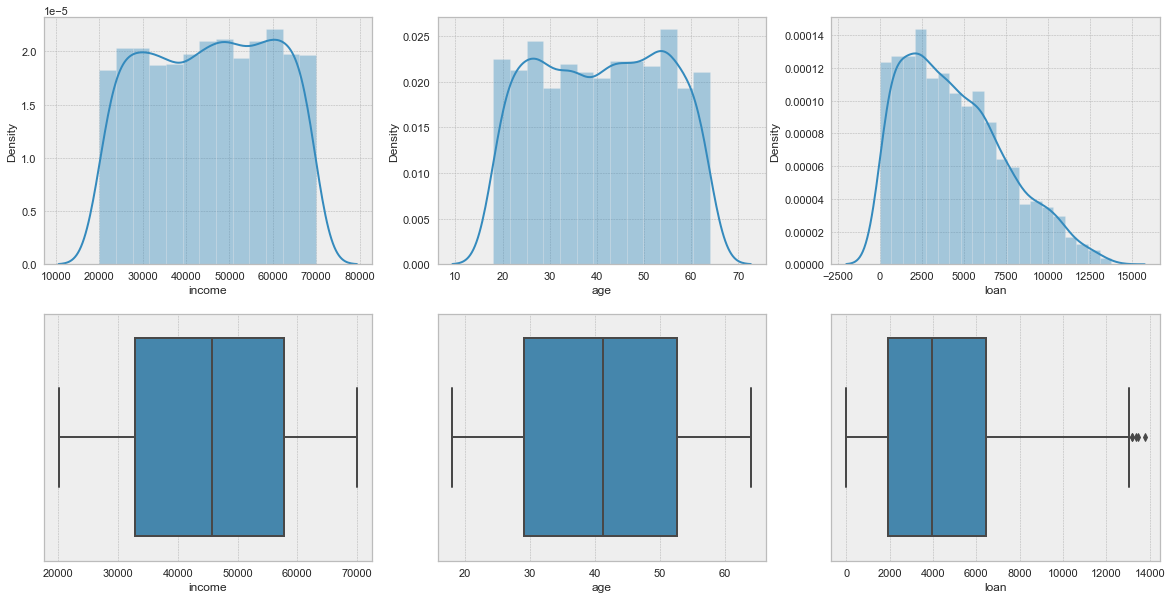

In [17]:
# mount grid 3 rows x 3 cols to receive charts
grid = GridSpec(2, 3)

# Distribution
plt.subplot(grid[0,0])
sns.distplot( df2['income'] )

plt.subplot(grid[0,1])
sns.distplot( df2['age'] )

plt.subplot(grid[0,2])
sns.distplot( df2['loan'] )

# Boxplot
plt.subplot(grid[1,0])
sns.boxplot( x=df2['income'])

plt.subplot(grid[1,1])
sns.boxplot( x=df2['age'] )

plt.subplot(grid[1,2])
sns.boxplot( x=df2['loan'] )

## 2.2 Analysing chart above

#### - We have outliers in the loans.

#### - We have great loans volume below $ 5.000

#### - 75% os loans area less than $ 6.000.

#### - 25% of customers are under 30 years

#### - 50% of customers incomes are over $ 40.000

# 3.0 FEATURE ENGINEERING

In [18]:
df3 = df2.copy()

## 3.1 Mind Map - Which leverages impact the granting of credit

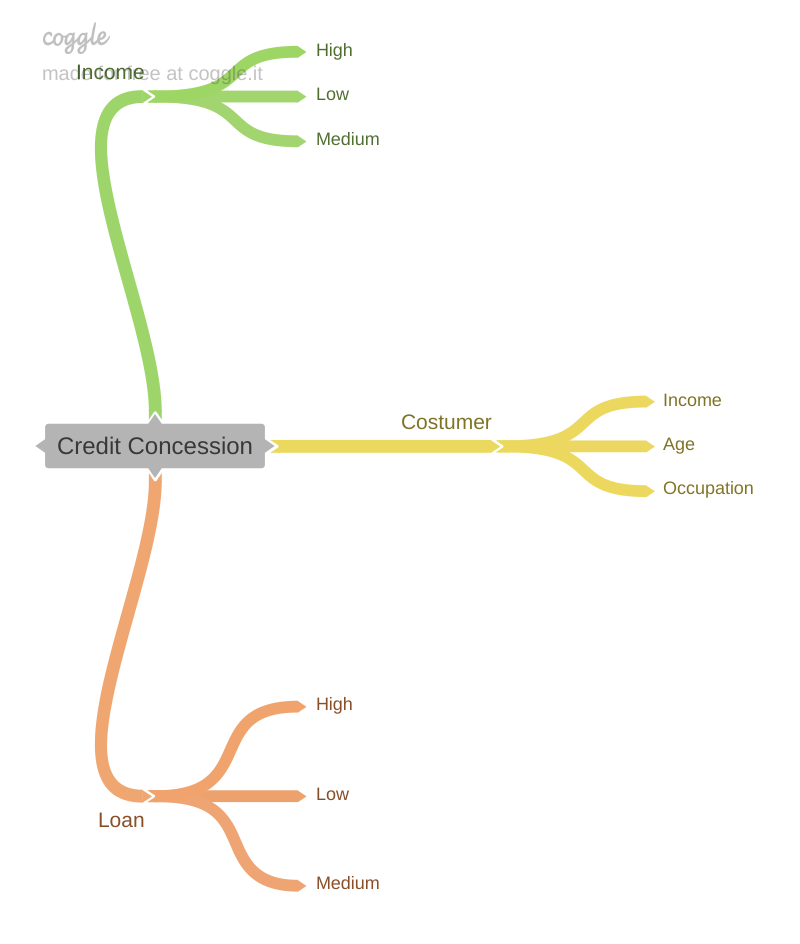

In [19]:
Image("img/Credit_Concession.png")

## 3.2 - Creating Hypotheses to get insigths

### 3.2.1 - Loan Assumptions

**1.** High loan values are more denied.

**2.** Mid Loan are more granted.

**3.** Loans are more applyed in the begining of the year. 

### 3.2.1 - Customers Assumptions

**1.** High age customers apply for more loans.

**2.** Young customers apply for lower loans.

**3.** Mid age customers apply for high loans.

**4.** Customers with higher level of studies apply less loans.

### 3.2.1 - Income Assumptions

**1.** Low income apply for more loans.

**2.** High income apply for high loans values.

**3.** Low income are more denied.

### 3.2.1 - Hypotheses Final List

**1.** High Loan are mode denied.

**2.** Median Loan are more granted.

**3.** High age customers apply for more loans.

**4.** Young customers apply for lower loans.

**5.** Mid age customers apply for high loans.

**6.** Low income apply for more loans.

**7.** High income apply for high loans values.

**8.** Low income are more denied.

## 3.3 - Feature Engineering

In [20]:
# Income
df3['income_type'] = df3['income'].apply(lambda x: 'low' if x<35000 else 'mid' if (x>=35000) & (x<50000) else 'high' ).astype('category')

# Age
df3['age_type'] = df3['age'].apply(lambda x: 'young' if x<=30 else 'mid' if (x>30) & (x<60) else 'high' ).astype('category')

# loan
df3['loan_type'] = df3['loan'].apply(lambda x: 'low' if x<=2000 else 'mid' if (x>2000) & (x<6000) else 'high' ).astype('category')

# 4.0 EXPLORATORY DATA ANALYSIS

In [21]:
df4 = df3.copy()

![Crisp 4](img/crisp4.jpg)

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='c#default', ylabel='Density'>

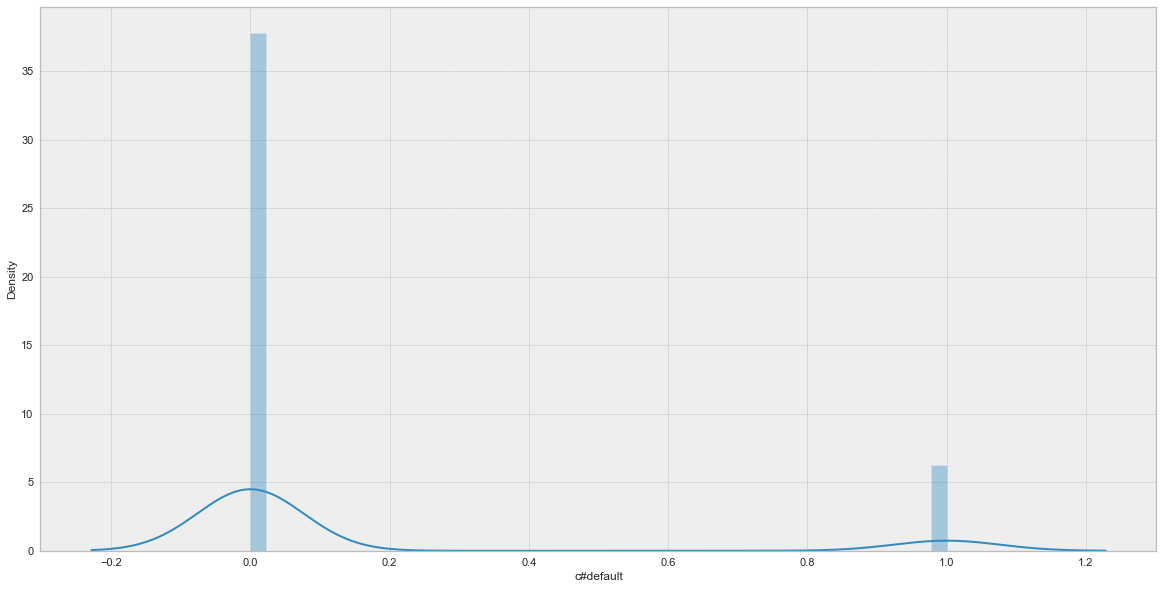

In [22]:
sns.distplot(df4['c#default'])

### 4.1.2 Analysing chart above

#### - We have an imbalanced dataset. We have to balanced the dataset, using undersamplig or oversampling techniques, to get a better model.

### 4.1.3 Numerical Variable

**Histograma**

**Definição:** uma uma representação gráfica em formato de retângulos cuja área é proporcional à frequência de uma variável quantitativa e cuja largura é igual ao intervalo de classe.

**Para que serve:** Um histograma é uma representação gráfica da distribuição de uma variável quantitativa contínua. Com o histograma pode-se visualizar a dispersão/concentração dos dados, bem como a assimetria/simetria dos dados. É muito utilizado para visualizar toda a distribuição de uma variável quantitativa. Foi introduzida pela primeira vez por Karl Pearson (OBS - É muito parecido com o gráfico de barras).

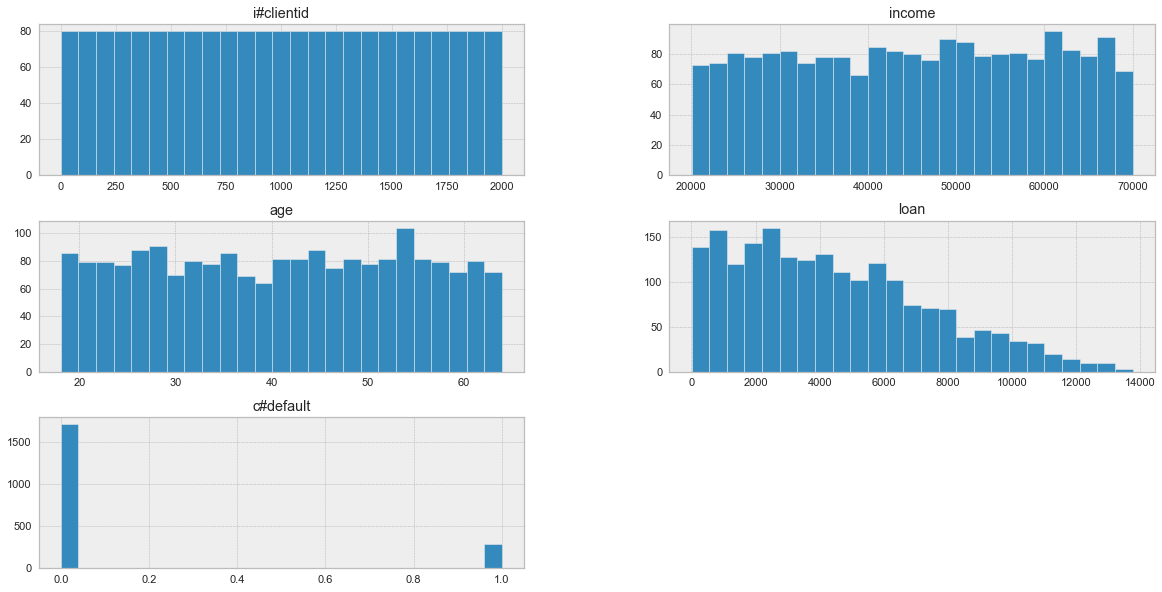

In [22]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an 

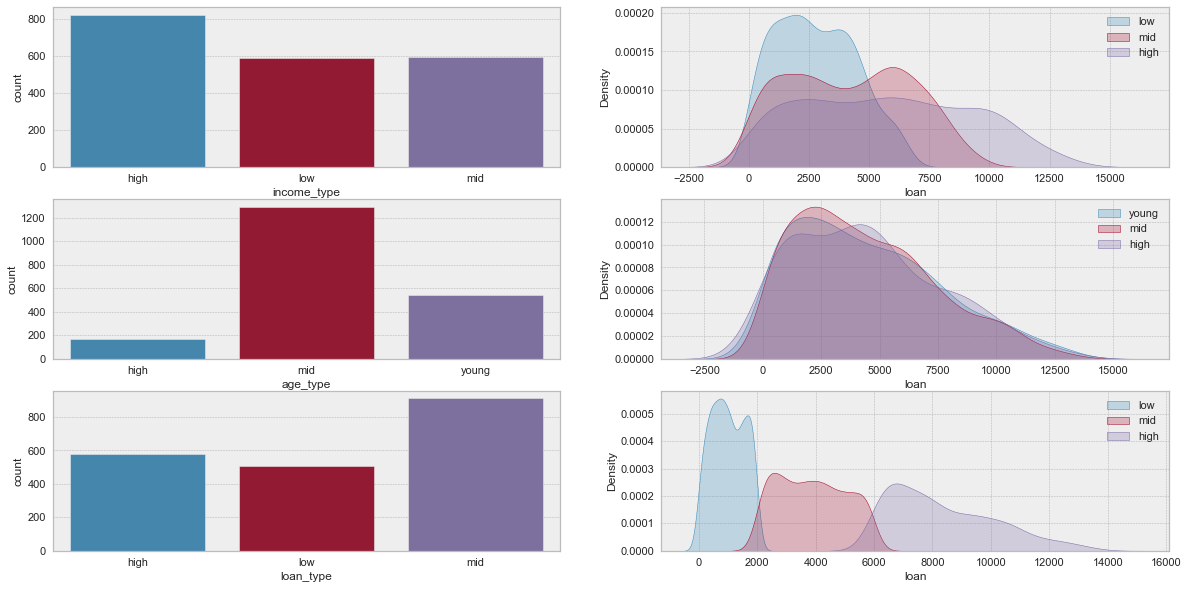

In [24]:
# state_holiday
plt.subplot(3, 2, 1)
sns.countplot(df4['income_type'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['income_type'] == 'low']['loan'], label='low', shade=True) 
sns.kdeplot(df4[df4['income_type'] == 'mid']['loan'], label='mid', shade=True)
sns.kdeplot(df4[df4['income_type'] == 'high']['loan'], label='high', shade=True)
plt.legend()

# age
plt.subplot(3, 2, 3)
sns.countplot(df4['age_type'])
plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['age_type'] == 'young']['loan'], label='young', shade=True) 
sns.kdeplot(df4[df4['age_type'] == 'mid']['loan'], label='mid', shade=True)
sns.kdeplot(df4[df4['age_type'] == 'high']['loan'], label='high', shade=True)
plt.legend()

#loan
plt.subplot(3, 2, 5)
sns.countplot(df4['loan_type'])
plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['loan_type'] == 'low']['loan'], label='low', shade=True, legend=True) 
sns.kdeplot(df4[df4['loan_type'] == 'mid']['loan'], label='mid', shade=True, legend=True)
sns.kdeplot(df4[df4['loan_type'] == 'high']['loan'], label='high', shade=True, legend=True)
plt.legend()

### 4.2 Statistics above

### - Low income loan maximum is $ 7.000

### - High income loan is in a large range of values, fom low to high values.

### - Loan types range is great to cluster customers classes.

## 4.2 Bivariate Analysis

In [23]:
df4.head()

,i#clientid,income,age,loan,c#default,income_type,age_type,loan_type
0,1,66155.921875,59.031250,8108.0,0,high,mid,high
1,2,34415.152344,48.125000,6564.0,0,low,mid,high
2,3,57317.171875,63.093750,8020.0,0,high,high,high
3,4,42709.535156,45.750000,6104.0,0,mid,mid,high
4,5,66952.687500,18.578125,8768.0,1,high,young,high


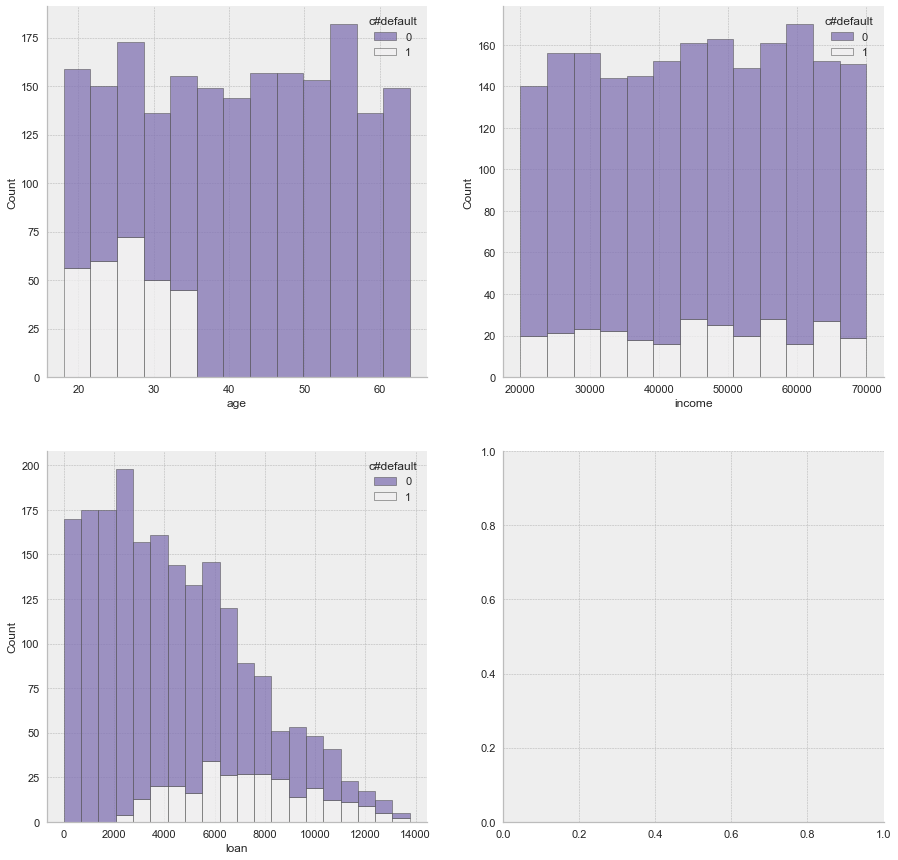

In [86]:
f, ax = plt.subplots(2,2,figsize=(15, 15))

sns.despine(f)

sns.histplot(
    df4,
    x="age", hue="c#default",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    ax=ax[0,0],
);

sns.histplot(
    df4,
    x="income", hue="c#default",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    ax=ax[0,1],
);

sns.histplot(
    df4,
    x="loan", hue="c#default",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    ax=ax[1,0],
);


# ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter());
# ax.set_xticks([20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000]);

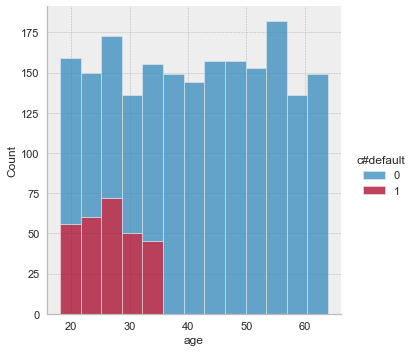

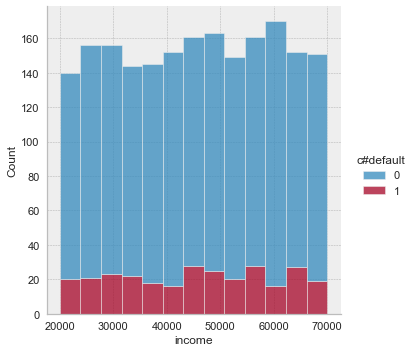

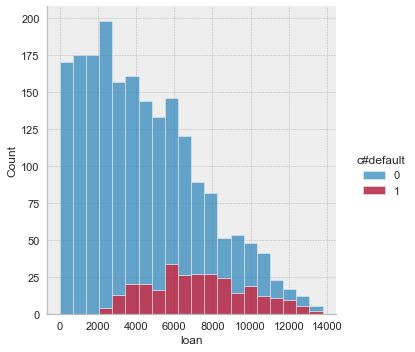

In [52]:
sns.displot(df4, x="age", hue="c#default", multiple="stack")

sns.displot(df4, x="income", hue="c#default", multiple="stack");

sns.displot(df4, x="loan", hue="c#default", multiple="stack");


### H1 - High loan values are more denied.

**False**, mid loans is more denied.

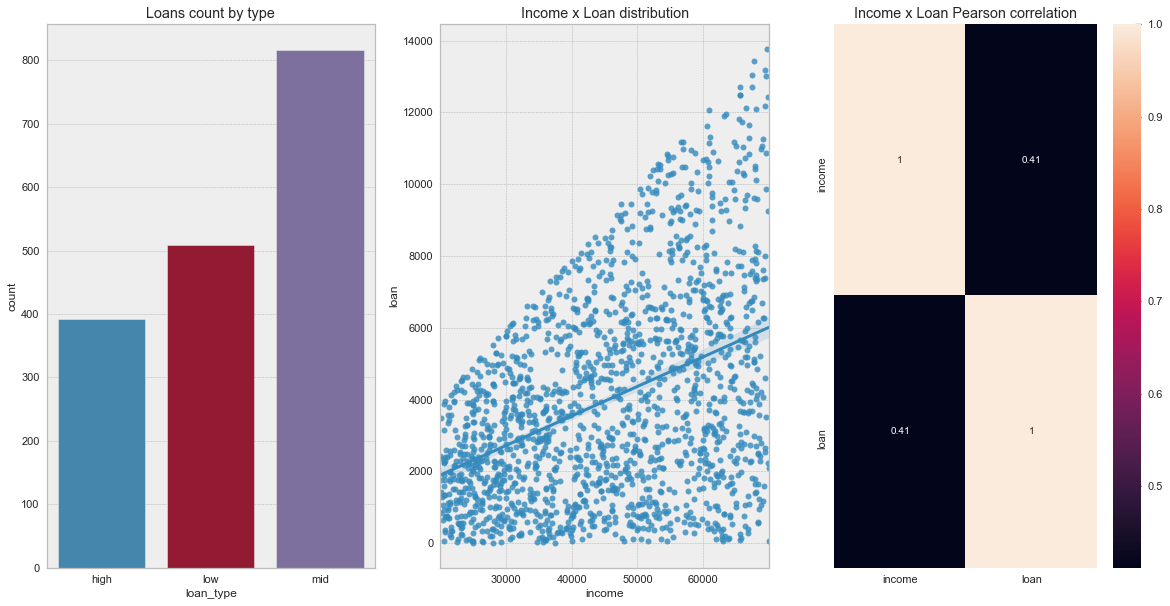

In [25]:
aux = df4[df4['c#default']==0]
aux_corr = aux[['income', 'loan']]
aux_agg = aux[['loan_type']].groupby('loan_type').size().to_frame('count').reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='loan_type', y='count', data=aux_agg).set_title('Loans count by type')

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Income x Loan Pearson correlation');

### H2 - Median Loan are more granted

**False**, High values are more granted.

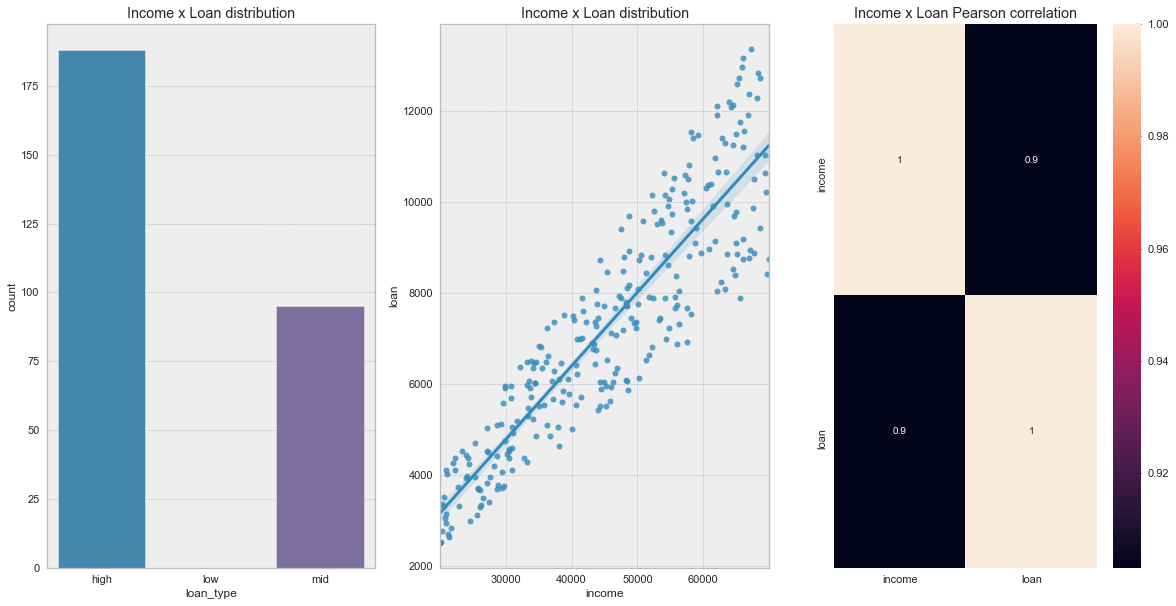

In [26]:
aux = df4[df4['c#default']==1]
aux_corr = aux[['income', 'loan']]
aux_loan_type = aux[['loan_type']].groupby('loan_type').size().to_frame('count').reset_index()

# loan types
plt.subplot(1, 3, 1)
sns.barplot(x='loan_type', y='count', data=aux_loan_type).set_title('Income x Loan distribution');

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Income x Loan Pearson correlation');


### H3 - High age customers apply for more loans.

**False**, mid age apply for more loans.

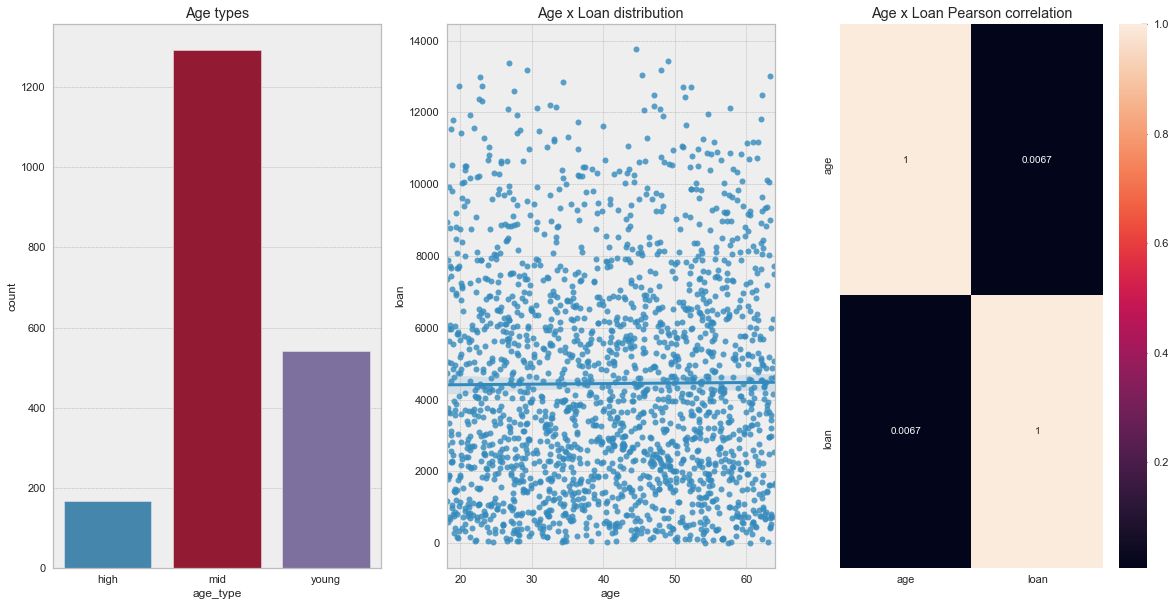

In [27]:
aux = df4[['age_type']].groupby('age_type').size().to_frame('count').reset_index()
aux_corr = df4[['age', 'loan']]

# age types
plt.subplot(1, 3, 1)
sns.barplot(x='age_type', y='count', data=aux).set_title('Age types');

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='age', y='loan', data=aux_corr).set_title('Age x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Age x Loan Pearson correlation');


### H4 - Young customers apply for lower loans.

**False**, mid age customers apply for lower loans.

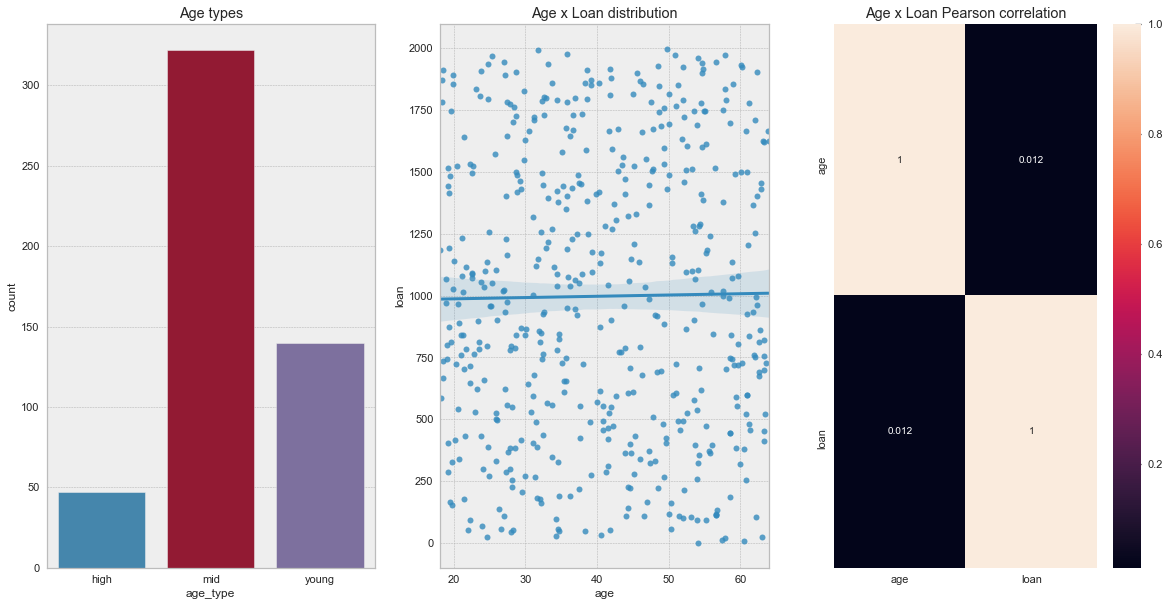

In [28]:
aux = df4[df4['loan_type']=='low']
aux_agg = aux[['age_type']].groupby(['age_type']).size().to_frame('count').reset_index()
aux_corr = aux[['age', 'loan']]
# age types
plt.subplot(1, 3, 1)
sns.barplot(x='age_type', y='count', data=aux_agg).set_title('Age types');

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='age', y='loan', data=aux_corr).set_title('Age x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Age x Loan Pearson correlation');


### H5 - Mid age customers apply for high loans..

**True**, mid age customers apply for high loans.

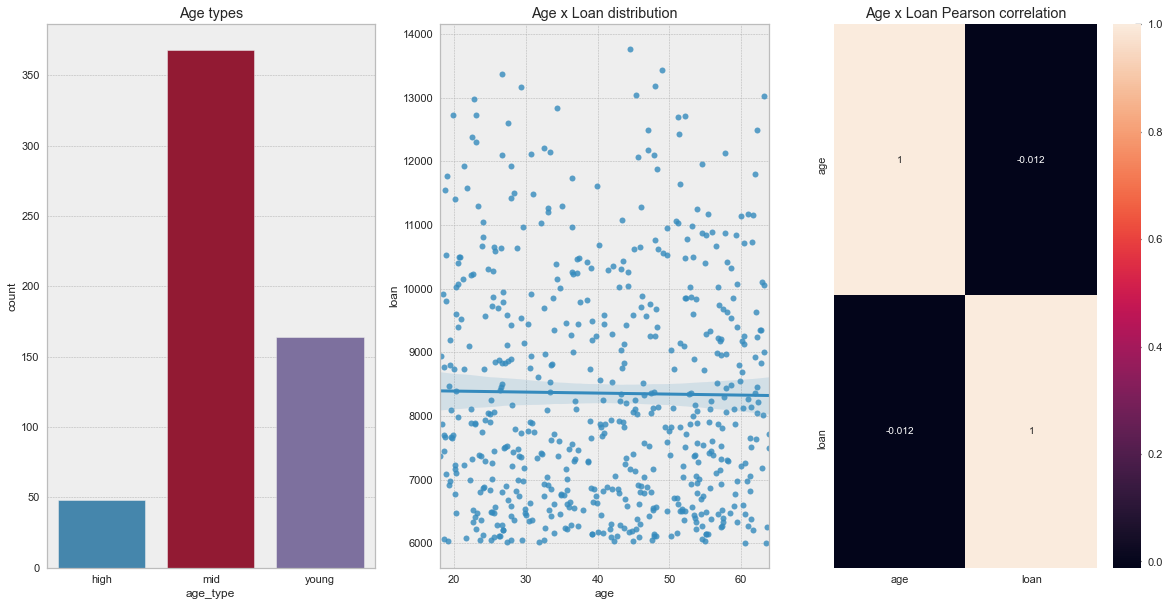

In [29]:
aux = df4[df4['loan_type']=='high']
aux_agg = aux[['age_type']].groupby(['age_type']).size().to_frame('count').reset_index()
aux_corr = aux[['age', 'loan']]

# age types
plt.subplot(1, 3, 1)
sns.barplot(x='age_type', y='count', data=aux_agg).set_title('Age types');

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='age', y='loan', data=aux_corr).set_title('Age x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Age x Loan Pearson correlation');


### H6 - Low income apply for more loans.

**False**, high income apply for more loans.

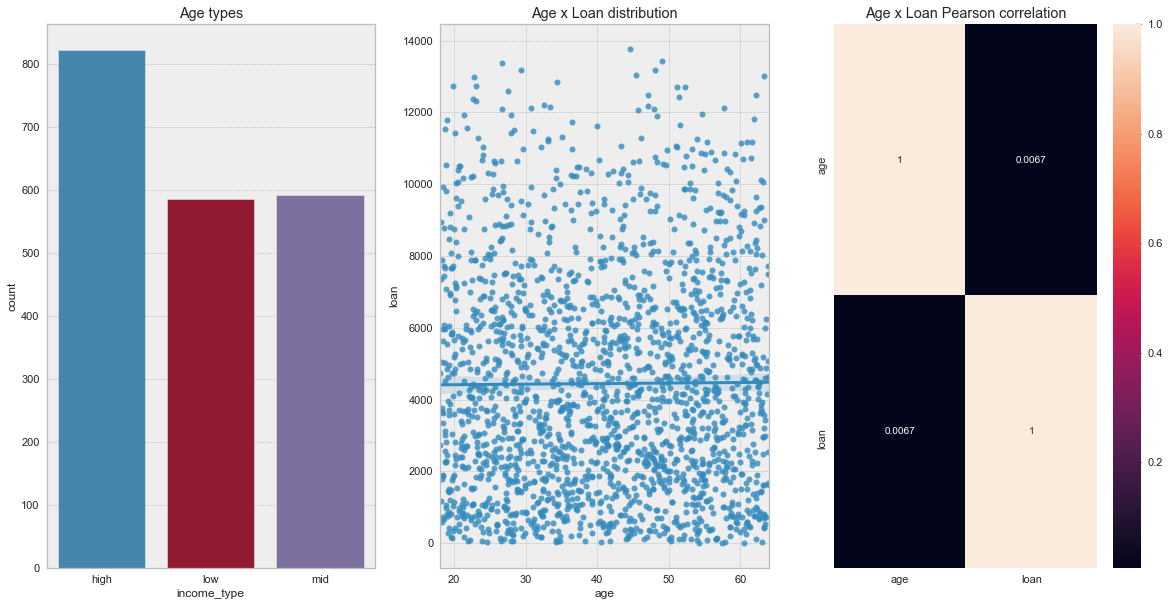

In [30]:
aux = df4[['income_type']].groupby('income_type').size().to_frame('count').reset_index()
aux_corr = df4[['age', 'loan']]

# age types
plt.subplot(1, 3, 1)
sns.barplot(x='income_type', y='count', data=aux).set_title('Age types');

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='age', y='loan', data=aux_corr).set_title('Age x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Age x Loan Pearson correlation');


### H7 - High income apply for high loans values.

**True**, high income apply for high loans values.

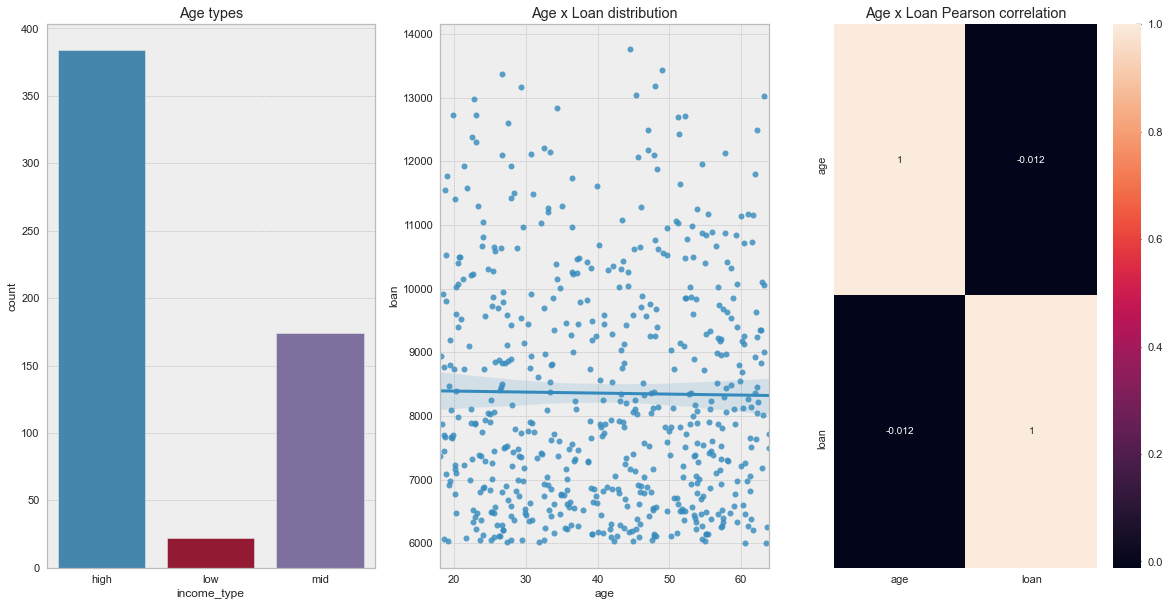

In [31]:
aux = df4[df4['loan_type']=='high']
aux_agg = aux[['income_type']].groupby('income_type').size().to_frame('count').reset_index()
aux_corr = aux[['age', 'loan']]

# age types
plt.subplot(1, 3, 1)
sns.barplot(x='income_type', y='count', data=aux_agg).set_title('Age types');

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='age', y='loan', data=aux_corr).set_title('Age x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Age x Loan Pearson correlation');


### H8 - Low income are mode denied.

**False**, high incomes are more denied.

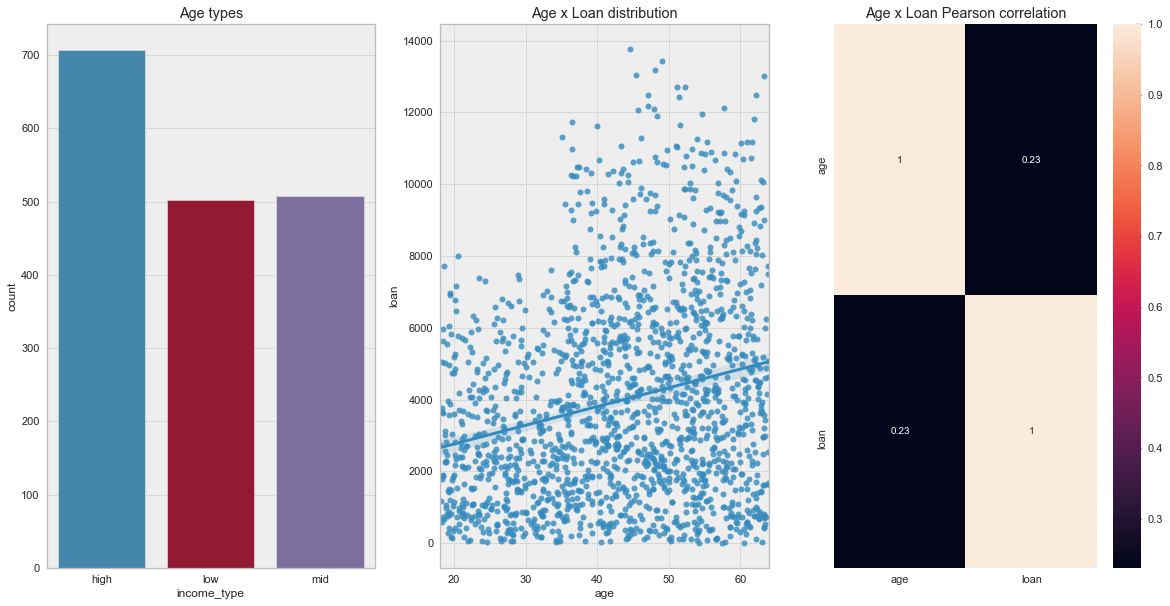

In [32]:
aux = df4[df4['c#default']==0]
aux.head()
aux_agg = aux[['income_type']].groupby('income_type').size().to_frame('count').reset_index()
aux_corr = aux[['age', 'loan']]
aux_agg.head()

# age types
plt.subplot(1, 3, 1)
sns.barplot(x='income_type', y='count', data=aux_agg).set_title('Age types');

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='age', y='loan', data=aux_corr).set_title('Age x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Age x Loan Pearson correlation');


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

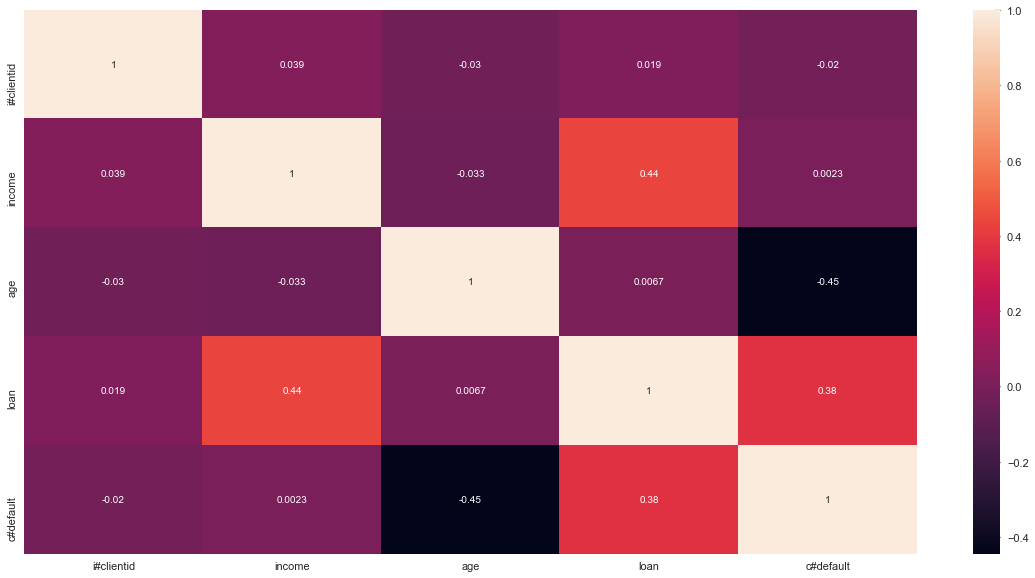

In [33]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

<AxesSubplot:>

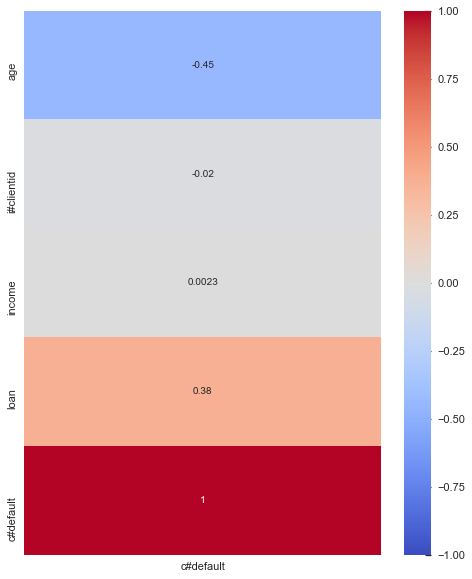

In [34]:
heatmap_numeric_w_dependent_variable(df4, 'c#default')

### 4.3.2 Categorical Attributes

In [35]:
df4.dtypes

i#clientid       uint16
income          float32
age             float32
loan            float32
c#default         uint8
income_type    category
age_type       category
loan_type      category
dtype: object

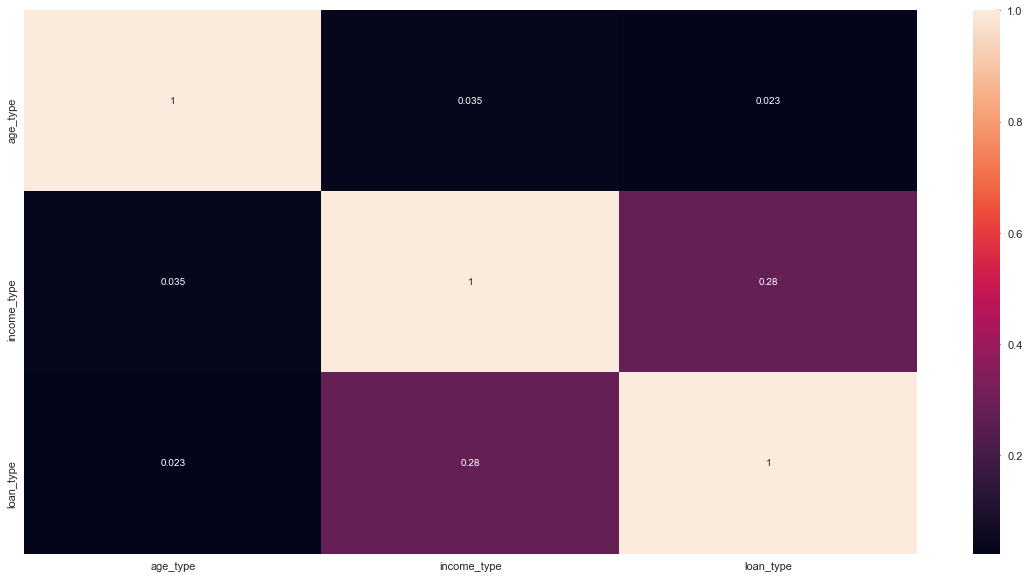

In [36]:
# only Categorical Attributes
a = df4.select_dtypes( include='category')

# Calculate Cramer_V
a1 = cramer_v(a['age_type'], a['age_type'])
a2 = cramer_v(a['age_type'], a['income_type'])
a3 = cramer_v(a['age_type'], a['loan_type'])

a4 = cramer_v(a['income_type'], a['age_type'])
a5 = cramer_v(a['income_type'], a['income_type'])
a6 = cramer_v(a['income_type'], a['loan_type'])

a7 = cramer_v(a['loan_type'], a['age_type'])
a8 = cramer_v(a['loan_type'], a['income_type'])
a9 = cramer_v(a['loan_type'], a['loan_type'])

# Final Dataset
d = pd.DataFrame({'age_type': [a1, a2, a3],
                 'income_type': [a4, a5, a6],
                 'loan_type': [a7, a8, a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True);


## 4.4 Benford´s Law Analysis

### 4.4.1 Create Benford´s Distribution

In [37]:
data = { 'digits': [1, 2, 3, 4, 5, 6, 7, 8, 9] }
df_benford = pd.DataFrame(data, dtype=np.int8)
df_benford['benford_proportion'] = df_benford['digits'].apply( lambda x: math.log10( 1+1/x ) )

### 4.4.2 Income analysis using Benford´s Law

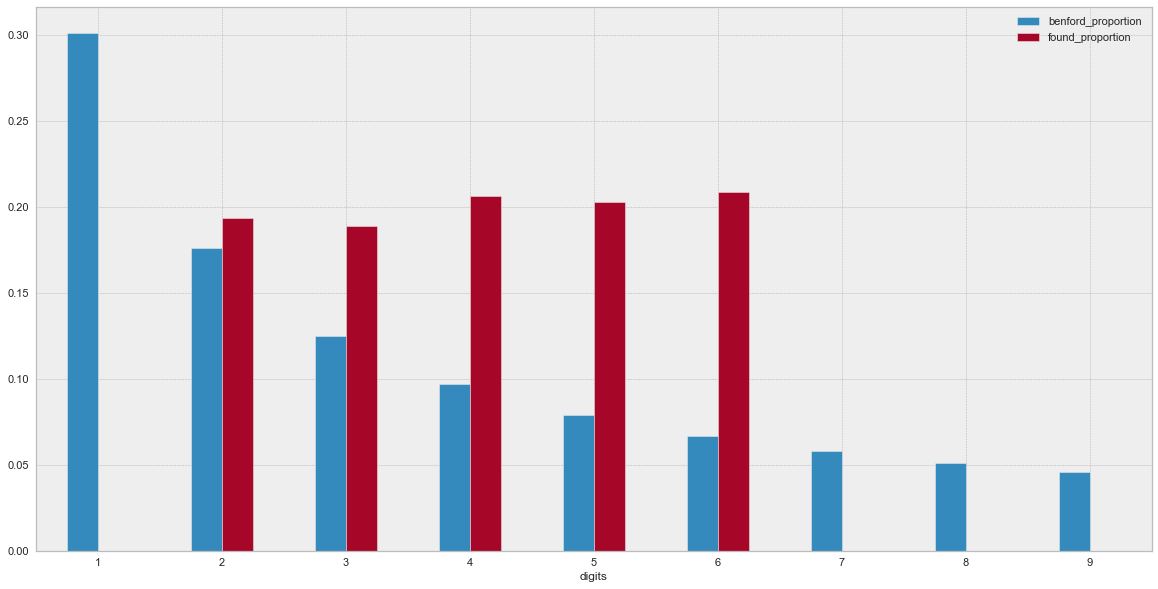

In [38]:
df_income = df4['income'].astype(str).str[0].to_frame('digits').astype(int8)
df_income = df_income.groupby('digits').size().to_frame('found_frequency').reset_index()
df_income['found_proportion'] = df_income['found_frequency']/df_income['found_frequency'].sum()

# merge
df_benford_analysis = pd.merge( df_benford, df_income, how='left', on='digits')

# replace NaN
df_benford_analysis['found_frequency'] = df_benford_analysis['found_frequency'].fillna(0)
df_benford_analysis['found_proportion'] = df_benford_analysis['found_proportion'].fillna(0)

# calculating conformity testing
#df_income['median_absolute_deviation'] = mad( df_income['found_proportion', 'benford_proportion'] )

df_benford_analysis.head(10)
ax = df_benford_analysis.plot.bar(x='digits', y=['benford_proportion', 'found_proportion'], rot=0)

### 4.4.3 Loan analysis using Benford´s Law

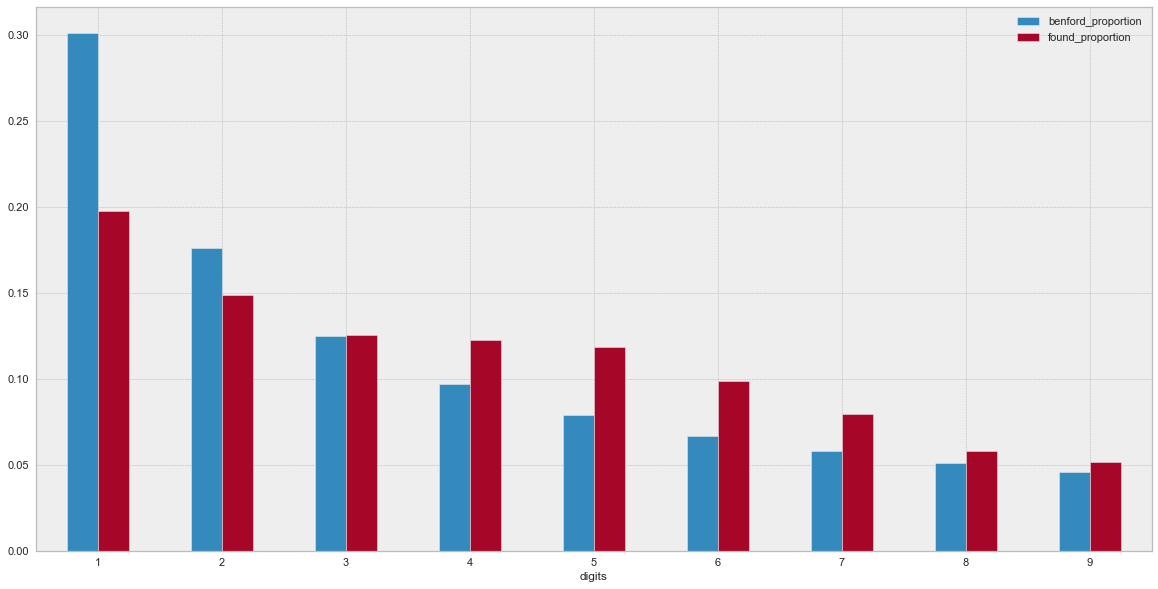

In [39]:
df_loan = df4['loan'].astype(str).str[0].to_frame('digits').astype(int8)
df_loan = df_loan.groupby('digits').size().to_frame('found_frequency').reset_index()
df_loan['found_proportion'] = df_loan['found_frequency']/df_loan['found_frequency'].sum()

# merge
df_benford_analysis = pd.merge( df_benford, df_loan, how='left', on='digits')

# replace NaN
df_benford_analysis['found_frequency'] = df_benford_analysis['found_frequency'].fillna(0)
df_benford_analysis['found_proportion'] = df_benford_analysis['found_proportion'].fillna(0)

df_benford_analysis.head(10)
ax = df_benford_analysis.plot.bar(x='digits', y=['benford_proportion', 'found_proportion'], rot=0)

## 4.5 Profile Report

In [40]:
profile = ProfileReport(df4, html={'style':{'full_width':True}})
#profile.to_notebook_iframe()
profile.tofile(output_file='c:/temp/credit_analysis_statistics.html')

KeyError: 'script_values'

# 5.0 DATA PREPARATION



In [41]:
df5=df4.copy()

![Crisp 5](img/crisp5.jpg)

## 5.1 Transformation

### 5.1.1 Encoding

In [42]:
df5['loan_type'].unique()

['high', 'low', 'mid']
Categories (3, object): ['high', 'low', 'mid']

In [43]:
# we´ll use a dict to associate the category with its hierarchy

ordinal_dict = { 'low':1, 'mid':2, 'high':3 }
df5['income_type'] = df5['income_type'].map( ordinal_dict ).astype('int8')
df5['loan_type'] = df5['loan_type'].map( ordinal_dict ).astype('int8')

ordinal_dict = { 'young':1, 'mid':2, 'high':3 }
df5['age_type'] = df5['age_type'].map( ordinal_dict ).astype('int8')

## 5.2 Split dataframe into training and test

**It´s very important to separate dataset in training and test before the escale transformation. Test data is like future data and should not contaminate training data.**

### 5.2.1 Split dataframe into predictors and target variable 

In [44]:
# create predicts variables
cols_drop = ['i#clientid', 'c#default']
X = df5.drop( cols_drop, axis=1).values # create list to predictors variables

# target variable
y = df5.iloc[:, 4].values # create list to target variable

### 5.2.2 Split dataframe into training and test

In [45]:
# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

#build training test dataframe
df_train =pd.DataFrame(X_train,columns   = ['income', 'age', 'loan', 'income_type', 'age_type', 'loan_type'])
df_test = pd.DataFrame(X_test,columns    = ['income', 'age', 'loan', 'income_type', 'age_type', 'loan_type'])
df_y_train =pd.DataFrame(y_train,columns = ['c#default'])


## 5.4 Normalization

**Used when we have a normal data distribution.**

## 5.5 Rescaling only training dataset

**- Min-Max Scaler (Sensível a Outlier)**

**- Robust Scaler**

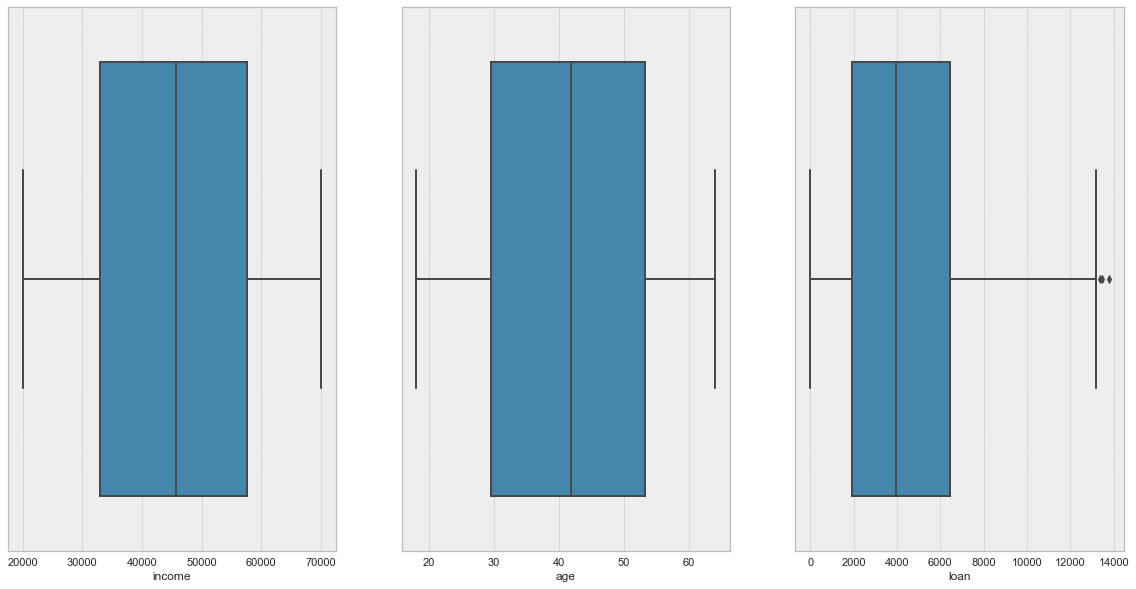

In [46]:
# Identificando Outliers
plt.subplot(1,3,1)
sns.boxplot( df_train['income']);

plt.subplot(1,3,2)
sns.boxplot( df_train['age']);

plt.subplot(1,3,3)
sns.boxplot( df_train['loan']);

In [47]:
rs = RobustScaler()
mms = MinMaxScaler()

# Aplica RobustScaler nas variáveis com Outliers

# loan
df_train['loan'] = rs.fit_transform(df_train[['loan']].values)
pickle.dump( rs, open('parameter/loan_scaler.pkl', 'wb'))

# Aplica MinMaxScaler nas variáveis sem Outliers

# income
df_train['income'] = mms.fit_transform(df_train[['income']].values)
pickle.dump( rs, open('parameter/income_scaler.pkl', 'wb'))
                                               
# age
df_train['age'] = mms.fit_transform(df_train[['age']].values)
pickle.dump( rs, open('parameter/age_scaler.pkl', 'wb'))

## 5.6 Balancing Dataset

Class distribution
0    1717
1     283
Name: c#default, dtype: int64


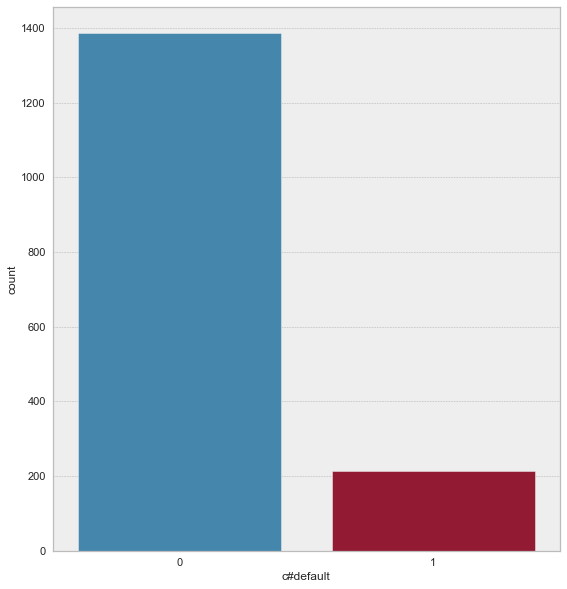

In [48]:
print('Class distribution\n{}'.format(df5['c#default'].value_counts()))

plt.subplot(1,2,1)
sns.countplot(x='c#default', data=df_y_train);

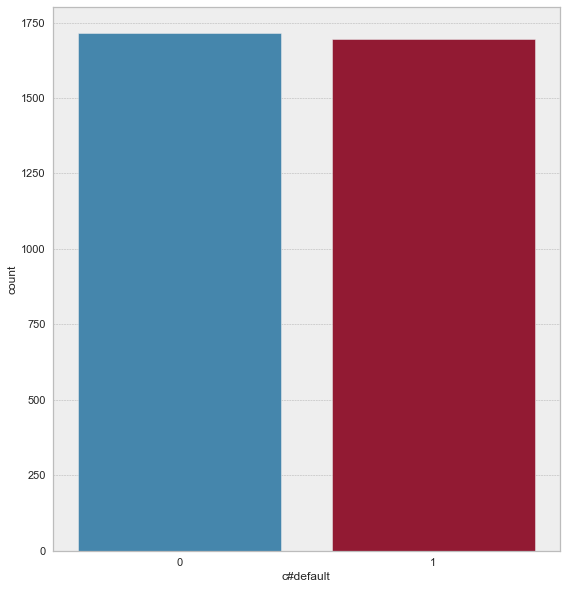

In [49]:
ratio_balanced = {0 : 1717, 1: 6*283}

#smt = SMOTE(sampling_strategy='auto')
smt = SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1)
X_df_train_resampled, y_df_train_resampled = smt.fit_sample(df_train, df_y_train)

plt.subplot(1,2,2)
sns.countplot(x='c#default', data=y_df_train_resampled);

# 6.0 FEATURE SELECTION

## 6.1 Boruta as Feature Selector

In [51]:
# training and teste dataset for Boruta
X_train_boruta = X_df_train_resampled.values
y_train_boruta = y_df_train_resampled.values.ravel()

#define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_boruta, y_train_boruta)

## 6.2 Best feature from Boruta

In [52]:
# Best features
cols_selected_boruta = boruta.support_.tolist()
cols_selected_boruta = df_train.iloc[:, cols_selected_boruta].columns.to_list()

# ignored by boruta
cols_ignored_boruta = list(np.setdiff1d(df_train.columns, cols_selected_boruta))

print(cols_selected_boruta, cols_ignored_boruta)

NameError: name 'boruta' is not defined

In [53]:
cols_selected_boruta = ['income', 'age', 'loan', 'income_type', 'age_type', 'loan_type' ]

# 7.0 MACHINE LEARNING MODELLING

In [54]:
# select cols to model 
X_df_train_resampled = X_df_train_resampled[cols_selected_boruta]
df_test              = df_test[cols_selected_boruta]

![Crisp 6](img/crisp6.jpg)

## 7.0 Confuson Matrix

#### True Positive (TP): It refers to the number of predictions where the classifier correctly predicts the positive class as positive.

#### True Negative (TN): It refers to the number of predictions where the classifier correctly predicts the negative class as negative.

#### False Positive (FP): It refers to the number of predictions where the classifier incorrectly predicts the negative class as positive.

#### False Negative (FN): It refers to the number of predictions where the classifier incorrectly predicts the positive class as negative.

![confusion_matrix](img/confusion_matrix.png)

## 7.0.1 Metrics

**Accuracy:** It gives you the overall accuracy of the model, meaning the fraction of the total samples that were correctly classified by the classifier. To calculate accuracy, use the following formula: **(TP+TN)/(TP+TN+FP+FN).**

**Misclassification Rate:** It tells you what fraction of predictions were incorrect. It is also known as Classification Error. You can calculate it using **(FP+FN)/(TP+TN+FP+FN) or (1-Accuracy).**

**Precision:** It tells you what fraction of predictions as a positive class were actually positive. To calculate precision, use the following formula: **TP/(TP+FP).**

**Recall:** True positive rate, sensitivity. It tells you what fraction of all positive samples were correctly predicted as positive by the classifier. It is also known as True Positive Rate (TPR), Sensitivity, Probability of Detection. To calculate Recall, use the following formula: **TP/(TP+FN).**]

**Specificity:** It tells you what fraction of all negative samples are correctly predicted as negative by the classifier. It is also known as True Negative Rate (TNR). To calculate specificity, use the following formula: **TN/(TN+FP).**

**F1-score:** It combines precision and recall into a single measure. Mathematically it’s the harmonic mean of precision and recall. It can be calculated as follows:

![f1_score](img/f1_score.png)

### Now, in a perfect world, we’d want a model that has a precision of 1 and a recall of 1. That means a F1-score of 1, i.e. a 100% accuracy which is often not the case for a machine learning model. So what we should try, is to get a higher precision with a higher recall value.

## 7.1 Baseline Classifier - Majority Learner/ZeroR

In [ ]:
# Baseline classifier train class
counter = collections.Counter(y_train)
base_line= np.array( [ counter[0] / (counter[0] + counter[1]), counter[1] / (counter[0] + counter[1]) ] )
base_line.max()

## 7.2 Naive Bayes Classifier  

In [58]:
y_df_train_resampled.dtypes

c#default    uint8
dtype: object

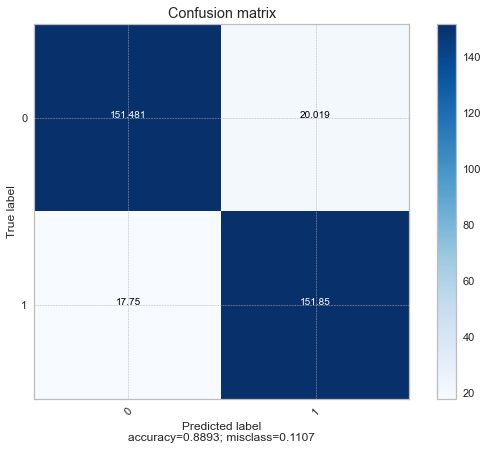

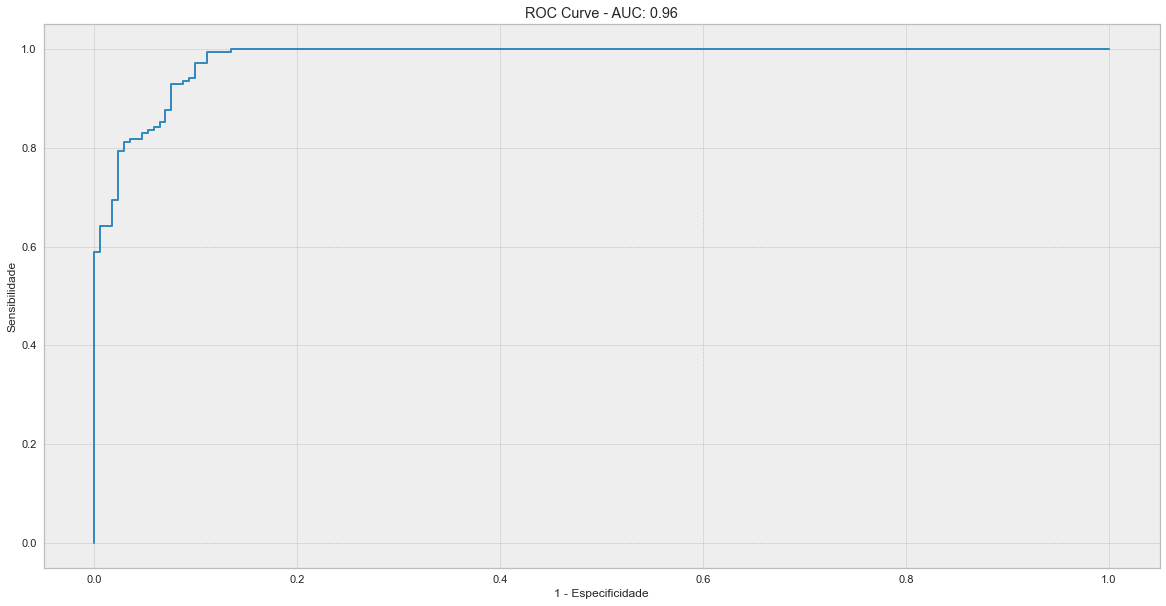

Confusion matrix:
[[151.481  20.019]
 [ 17.75  151.85 ]]



,Classifier Name,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,Naive Bayes Classifier,0.89,0.88,0.9,0.89,0.88,0.9,0.89,0.96,0.78,0.78


In [59]:
nb = GaussianNB()
nb_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'Naive Bayes Classifier', nb, 10, 100, verbose=False)
nb_result_cv

## 7.3 Decision Tree Classifier  

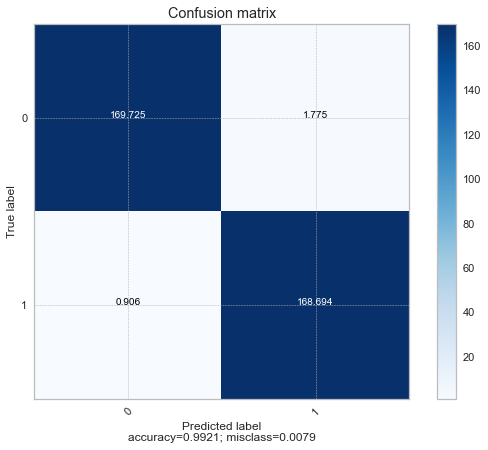

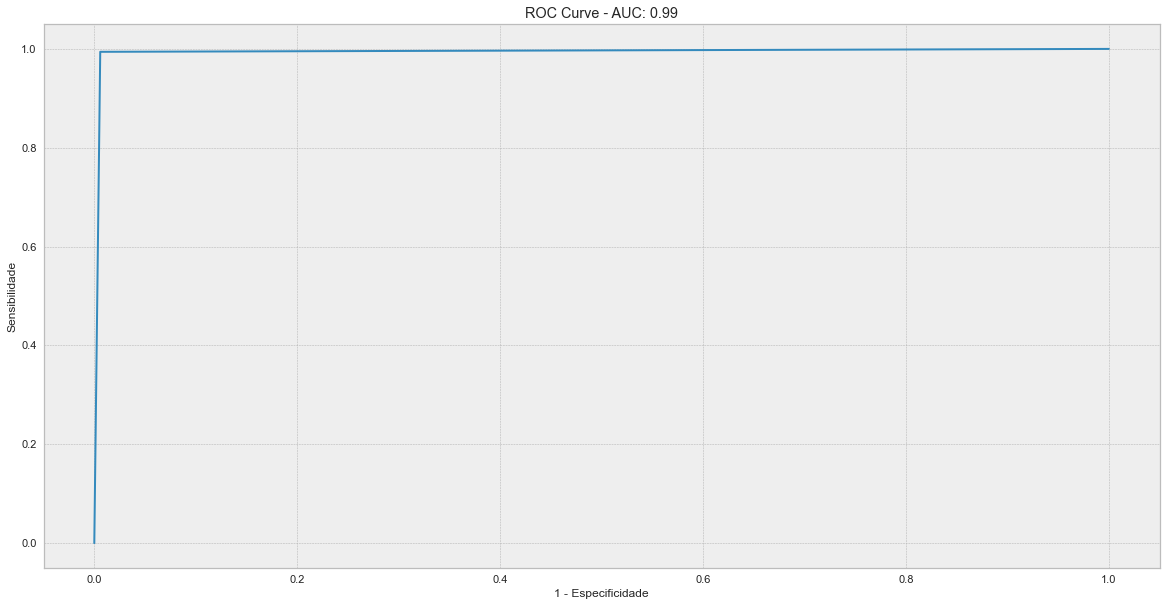

Confusion matrix:
[[169.725   1.775]
 [  0.906 168.694]]

              precision    recall  f1-score   support

           0     0.9942    0.9942    0.9942       171
           1     0.9941    0.9941    0.9941       170

    accuracy                         0.9941       341
   macro avg     0.9941    0.9941    0.9941       341
weighted avg     0.9941    0.9941    0.9941       341



,Classifier Name,Accuracy score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,DecisionTreeClassifier,0.99,0.99,0.99,0.99,0.99,0.98,0.98


In [100]:
dtc = DecisionTreeClassifier()
dtc_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'DecisionTreeClassifier', dtc, 10, 100, verbose=False)
dtc_result_cv

## 7.4 KNN Classifier  

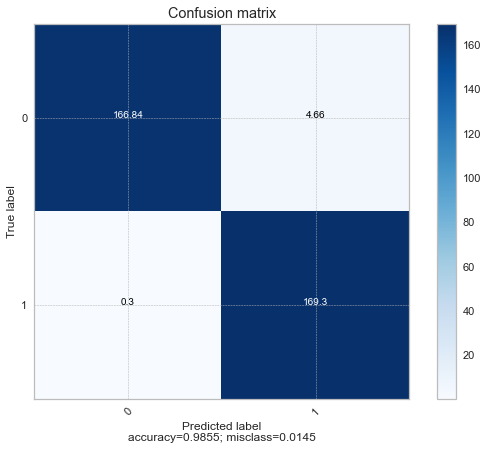

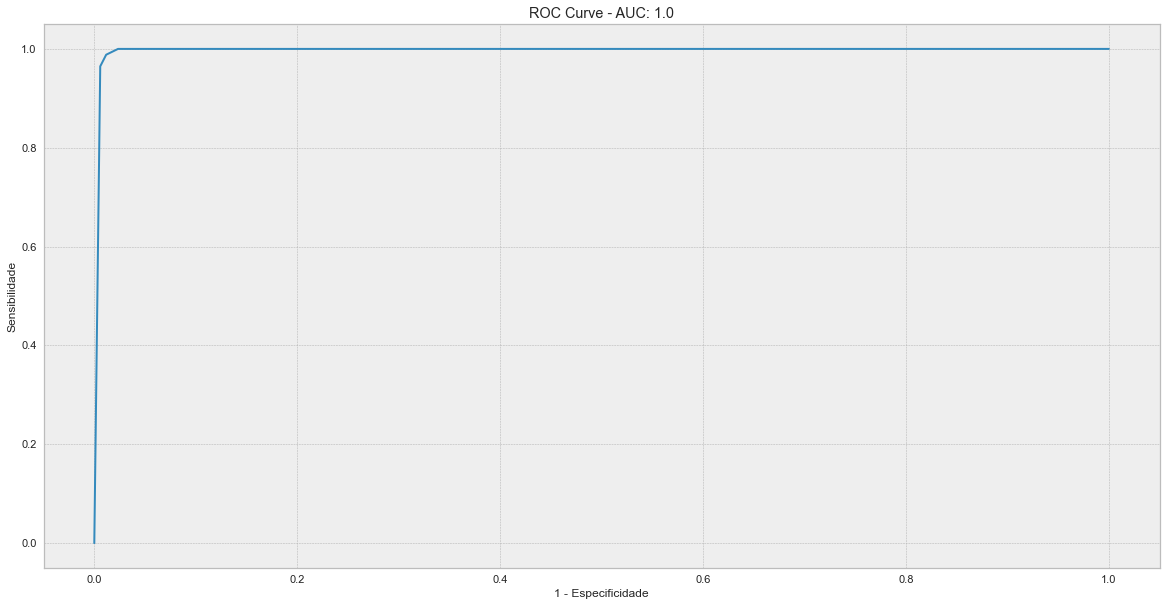

Confusion matrix:
[[166.84   4.66]
 [  0.3  169.3 ]]

              precision    recall  f1-score   support

           0     1.0000    0.9766    0.9882       171
           1     0.9770    1.0000    0.9884       170

    accuracy                         0.9883       341
   macro avg     0.9885    0.9883    0.9883       341
weighted avg     0.9885    0.9883    0.9883       341



,Classifier Name,Accuracy score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,KNN Classifier,0.99,0.97,1.0,0.99,1.0,0.97,0.97


In [102]:
knn = KNeighborsClassifier()
knn_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'KNN Classifier', knn, 10, 100, verbose=False)
knn_result_cv

## 7.5 LogisticRegression Classifier

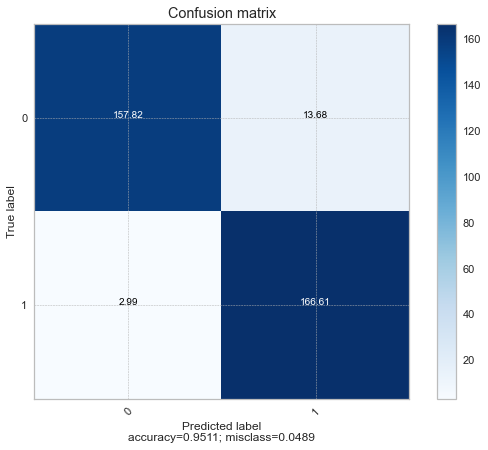

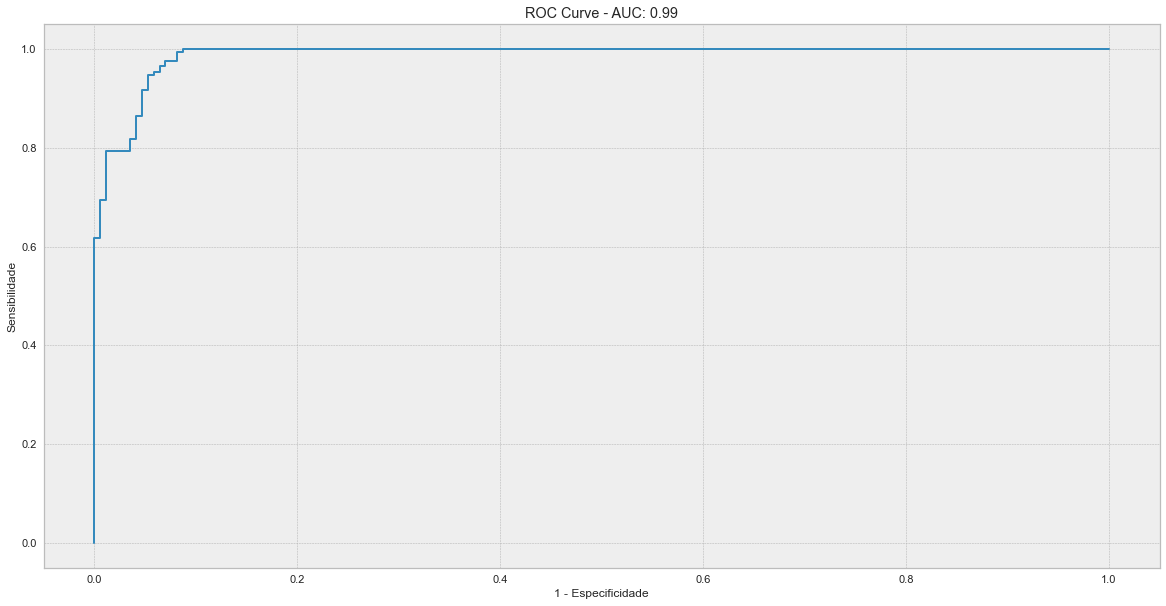

Confusion matrix:
[[157.82  13.68]
 [  2.99 166.61]]

              precision    recall  f1-score   support

           0     0.9581    0.9357    0.9467       171
           1     0.9368    0.9588    0.9477       170

    accuracy                         0.9472       341
   macro avg     0.9474    0.9472    0.9472       341
weighted avg     0.9475    0.9472    0.9472       341



,Classifier Name,Accuracy score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,LogisticRegression Classifier,0.95,0.92,0.98,0.95,0.99,0.9,0.9


In [103]:
lr = LogisticRegression()
lr_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'LogisticRegression Classifier', lr, 10, 100, verbose=False)
lr_result_cv

## 7.6 Support Vector Machine Classifier

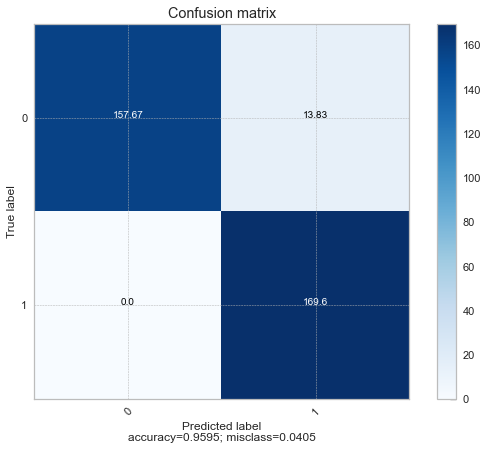

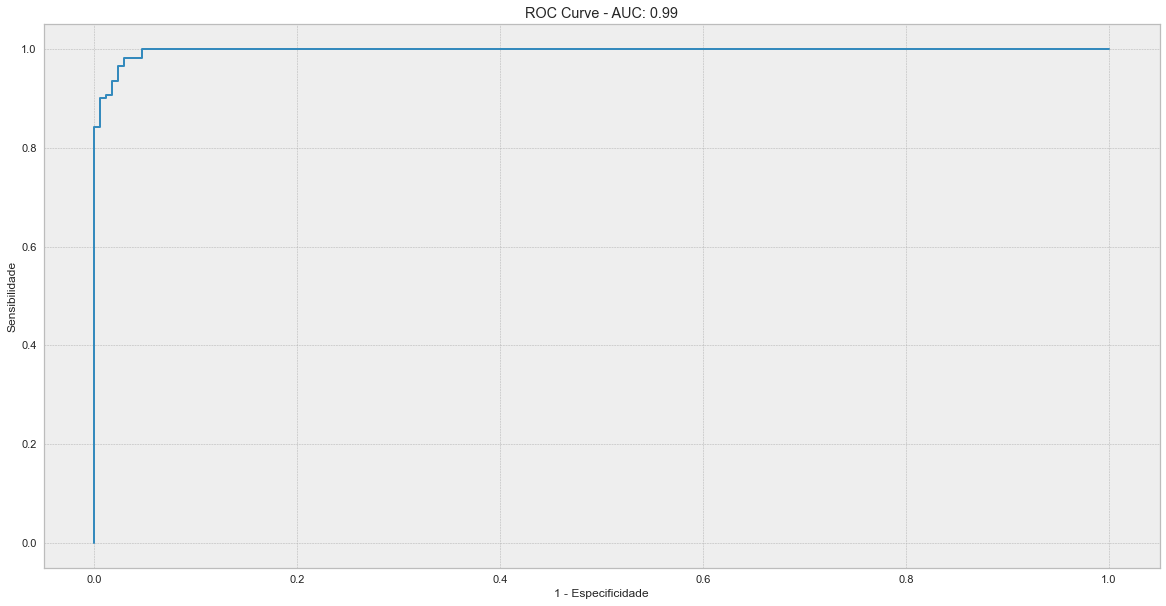

Confusion matrix:
[[157.67  13.83]
 [  0.   169.6 ]]

              precision    recall  f1-score   support

           0     1.0000    0.9298    0.9636       171
           1     0.9341    1.0000    0.9659       170

    accuracy                         0.9648       341
   macro avg     0.9670    0.9649    0.9648       341
weighted avg     0.9671    0.9648    0.9648       341



,Classifier Name,Accuracy score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,SVM Classifier,0.96,0.92,1.0,0.96,0.99,0.92,0.92


In [105]:
svm = SVC( probability=True )
svm_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'SVM Classifier', svm, 10, 10, verbose=False)
svm_result_cv

## 7.7 Neural Network Classifier

C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimi

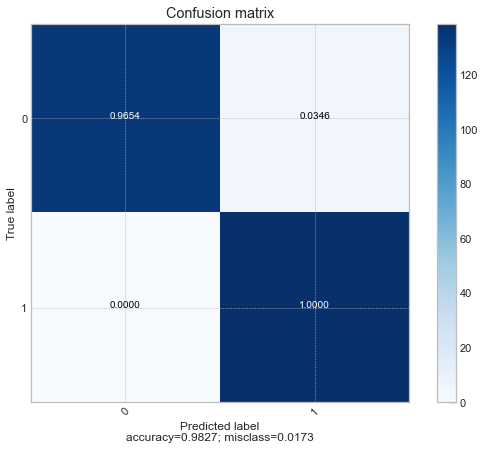

Confusion matrix:
[[133.8   4.8]
 [  0.  138.6]]

              precision    recall  f1-score   support

           0     1.0000    0.9493    0.9740       138
           1     0.9521    1.0000    0.9754       139

    accuracy                         0.9747       277
   macro avg     0.9760    0.9746    0.9747       277
weighted avg     0.9759    0.9747    0.9747       277



In [63]:
mlp = MLPClassifier(verbose=False)
mlp_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'NeuralNertwork Classifier', mlp, 10, 100, verbose=False)

## 7.8 Deep Learning Neural Network Classifier


****** Running 1/10 ******
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/100
2494/2494 [==============================] - 1s 463us/step - loss: 0.8874 - binary_accuracy: 0.5000
Epoch 2/100
2494/2494 [==============================] - 0s 4us/step - loss: 0.8697 - binary_accuracy: 0.5000
Epoch 3/100
2494/2494 [==============================] - 0s 3us/step - loss: 0.8533 - binary_accuracy: 0.5000
Epoch 4/100
2494/2494 [==============================] - 0s 5us/step - loss: 0.8389 - binary_accuracy: 0.5000
Epoch 5/100
2494/2494 [==============================] - 0s 6us/step - loss: 0.8249 - binary_accuracy: 0.5004
Epoch 6/100
2494/2494 [==============================] - 0s 6us/step - loss: 0.8120 - binary_accuracy: 0.4868
Epoch 7/100
2494/2494 [==============================] - 0s 5us/step - loss: 0.7997 - binary_accuracy: 0.4796
Epoch 8/100
2494/2494 [==============================] - 0s 4us/step - loss: 0.7888 - binary_accuracy: 0.

2494/2494 [==============================] - 0s 6us/step - loss: 0.3590 - binary_accuracy: 0.8629
Epoch 43/100
2494/2494 [==============================] - 0s 6us/step - loss: 0.3549 - binary_accuracy: 0.8633
Epoch 44/100
2494/2494 [==============================] - 0s 6us/step - loss: 0.3509 - binary_accuracy: 0.8633
Epoch 45/100
2494/2494 [==============================] - 0s 5us/step - loss: 0.3471 - binary_accuracy: 0.8625
Epoch 46/100
2494/2494 [==============================] - 0s 6us/step - loss: 0.3434 - binary_accuracy: 0.8621
Epoch 47/100
2494/2494 [==============================] - 0s 6us/step - loss: 0.3399 - binary_accuracy: 0.8617
Epoch 48/100
2494/2494 [==============================] - 0s 8us/step - loss: 0.3364 - binary_accuracy: 0.8625
Epoch 49/100
2494/2494 [==============================] - 0s 4us/step - loss: 0.3331 - binary_accuracy: 0.8637
Epoch 50/100
2494/2494 [==============================] - 0s 4us/step - loss: 0.3299 - binary_accuracy: 0.8629
Epoch 51/100
2

2495/2495 [==============================] - 0s 3us/step - loss: 0.2383 - binary_accuracy: 0.9030
Epoch 89/100
2495/2495 [==============================] - 0s 4us/step - loss: 0.2371 - binary_accuracy: 0.9030
Epoch 90/100
2495/2495 [==============================] - 0s 3us/step - loss: 0.2359 - binary_accuracy: 0.9042
Epoch 91/100
2495/2495 [==============================] - 0s 4us/step - loss: 0.2348 - binary_accuracy: 0.9046
Epoch 92/100
2495/2495 [==============================] - 0s 2us/step - loss: 0.2336 - binary_accuracy: 0.9042
Epoch 93/100
2495/2495 [==============================] - 0s 4us/step - loss: 0.2325 - binary_accuracy: 0.9050
Epoch 94/100
2495/2495 [==============================] - 0s 4us/step - loss: 0.2314 - binary_accuracy: 0.9046
Epoch 95/100
2495/2495 [==============================] - 0s 3us/step - loss: 0.2306 - binary_accuracy: 0.9074
Epoch 96/100
2495/2495 [==============================] - 0s 4us/step - loss: 0.2295 - binary_accuracy: 0.9074
Epoch 97/100
2

2495/2495 [==============================] - 0s 3us/step - loss: 0.5997 - binary_accuracy: 0.7587
Epoch 35/100
2495/2495 [==============================] - 0s 4us/step - loss: 0.5959 - binary_accuracy: 0.7627
Epoch 36/100
2495/2495 [==============================] - 0s 4us/step - loss: 0.5922 - binary_accuracy: 0.7607
Epoch 37/100
2495/2495 [==============================] - 0s 4us/step - loss: 0.5883 - binary_accuracy: 0.7619
Epoch 38/100
2495/2495 [==============================] - 0s 2us/step - loss: 0.5844 - binary_accuracy: 0.7703
Epoch 39/100
2495/2495 [==============================] - 0s 3us/step - loss: 0.5804 - binary_accuracy: 0.7760
Epoch 40/100
2495/2495 [==============================] - 0s 4us/step - loss: 0.5763 - binary_accuracy: 0.7711
Epoch 41/100
2495/2495 [==============================] - 0s 5us/step - loss: 0.5721 - binary_accuracy: 0.7683
Epoch 42/100
2495/2495 [==============================] - 0s 5us/step - loss: 0.5678 - binary_accuracy: 0.7667
Epoch 43/100
2

2495/2495 [==============================] - 0s 3us/step - loss: 0.4491 - binary_accuracy: 0.8770
Epoch 81/100
2495/2495 [==============================] - 0s 4us/step - loss: 0.4455 - binary_accuracy: 0.8766
Epoch 82/100
2495/2495 [==============================] - 0s 4us/step - loss: 0.4419 - binary_accuracy: 0.8778
Epoch 83/100
2495/2495 [==============================] - 0s 4us/step - loss: 0.4385 - binary_accuracy: 0.8786
Epoch 84/100
2495/2495 [==============================] - 0s 4us/step - loss: 0.4350 - binary_accuracy: 0.8818
Epoch 85/100
2495/2495 [==============================] - 0s 6us/step - loss: 0.4317 - binary_accuracy: 0.8830
Epoch 86/100
2495/2495 [==============================] - 0s 6us/step - loss: 0.4282 - binary_accuracy: 0.8838
Epoch 87/100
2495/2495 [==============================] - 0s 6us/step - loss: 0.4248 - binary_accuracy: 0.8866
Epoch 88/100
2495/2495 [==============================] - 0s 6us/step - loss: 0.4215 - binary_accuracy: 0.8894
Epoch 89/100
2

2495/2495 [==============================] - 0s 4us/step - loss: 0.6374 - binary_accuracy: 0.7271
Epoch 27/100
2495/2495 [==============================] - 0s 4us/step - loss: 0.6336 - binary_accuracy: 0.7395
Epoch 28/100
2495/2495 [==============================] - 0s 5us/step - loss: 0.6298 - binary_accuracy: 0.7543
Epoch 29/100
2495/2495 [==============================] - 0s 5us/step - loss: 0.6260 - binary_accuracy: 0.7607
Epoch 30/100
2495/2495 [==============================] - 0s 6us/step - loss: 0.6221 - binary_accuracy: 0.7671
Epoch 31/100
2495/2495 [==============================] - 0s 7us/step - loss: 0.6184 - binary_accuracy: 0.7683
Epoch 32/100
2495/2495 [==============================] - 0s 7us/step - loss: 0.6145 - binary_accuracy: 0.7711
Epoch 33/100
2495/2495 [==============================] - 0s 5us/step - loss: 0.6107 - binary_accuracy: 0.7735
Epoch 34/100
2495/2495 [==============================] - 0s 4us/step - loss: 0.6071 - binary_accuracy: 0.7800
Epoch 35/100
2

2495/2495 [==============================] - 0s 4us/step - loss: 0.2842 - binary_accuracy: 0.8862
Epoch 73/100
2495/2495 [==============================] - 0s 4us/step - loss: 0.2806 - binary_accuracy: 0.8878
Epoch 74/100
2495/2495 [==============================] - 0s 4us/step - loss: 0.2771 - binary_accuracy: 0.8890
Epoch 75/100
2495/2495 [==============================] - 0s 3us/step - loss: 0.2736 - binary_accuracy: 0.8902
Epoch 76/100
2495/2495 [==============================] - 0s 4us/step - loss: 0.2702 - binary_accuracy: 0.8918
Epoch 77/100
2495/2495 [==============================] - 0s 4us/step - loss: 0.2670 - binary_accuracy: 0.8910
Epoch 78/100
2495/2495 [==============================] - 0s 3us/step - loss: 0.2639 - binary_accuracy: 0.8910
Epoch 79/100
2495/2495 [==============================] - 0s 3us/step - loss: 0.2609 - binary_accuracy: 0.8918
Epoch 80/100
2495/2495 [==============================] - 0s 4us/step - loss: 0.2579 - binary_accuracy: 0.8914
Epoch 81/100
2

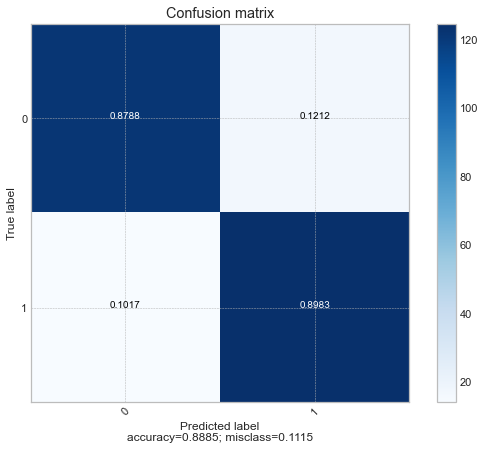

Confusion matrix:
[[121.8  16.8]
 [ 14.1 124.5]]

              precision    recall  f1-score   support

           0     0.8905    0.8841    0.8873       138
           1     0.8857    0.8921    0.8889       139

    accuracy                         0.8881       277
   macro avg     0.8881    0.8881    0.8881       277
weighted avg     0.8881    0.8881    0.8881       277



In [67]:
def createDeepLearningNetWork():
    keras_classifier = Sequential()
    # 1st layer
    keras_classifier.add( Dense(units=6, # neurons
                     activation='relu',
                     input_dim=6) )
    # 2nd layer
    keras_classifier.add( Dense(units=6, # neurons
                     activation='relu') )

    # out layer
    keras_classifier.add( Dense(units=1, # neurons
                     activation='sigmoid') )
    
    # create optmizer
    optmizer = keras.optimizers.Adam(lr=0.001, decay=0.0001, clipvalue=0.5)

    #  compile neural network
    keras_classifier.compile(optimizer=optmizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
    return keras_classifier

keras_classifier = KerasClassifier( build_fn = createDeepLearningNetWork, epochs=100, batch_size=512)

keras_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'Keras Classifier', keras_classifier, 10, 10, verbose=True)


## 7.9 Random Forest Classifier

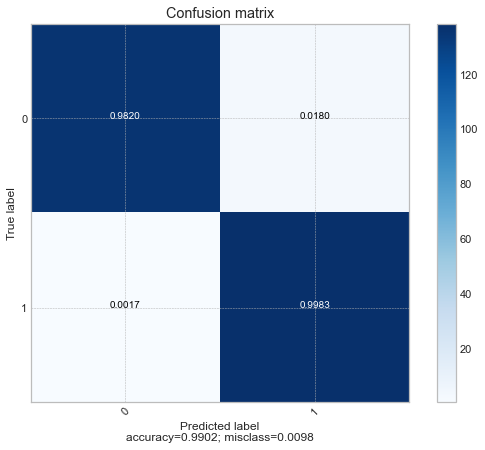

Confusion matrix:
[[136.11   2.49]
 [  0.23 138.37]]

              precision    recall  f1-score   support

           0     1.0000    0.9855    0.9927       138
           1     0.9858    1.0000    0.9929       139

    accuracy                         0.9928       277
   macro avg     0.9929    0.9928    0.9928       277
weighted avg     0.9929    0.9928    0.9928       277



In [68]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
rf_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'Random Forest Classifier', rf, 10, 100, verbose=False)

## 7.10 XGBoost Classifier

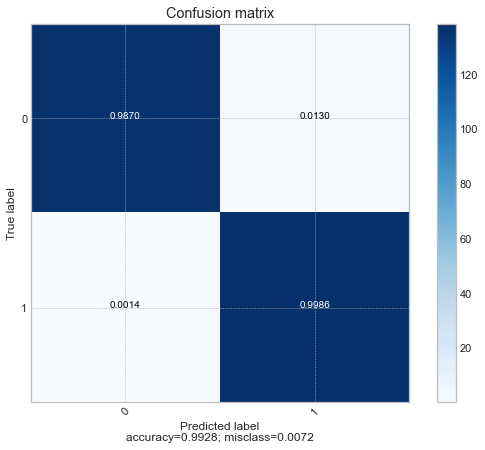

Confusion matrix:
[[136.798   1.802]
 [  0.193 138.407]]

              precision    recall  f1-score   support

           0     1.0000    0.9928    0.9964       138
           1     0.9929    1.0000    0.9964       139

    accuracy                         0.9964       277
   macro avg     0.9964    0.9964    0.9964       277
weighted avg     0.9964    0.9964    0.9964       277



In [69]:
xgb_model = XGBClassifier(n_jobs=-1, subsample=1.0, n_estimators=210, min_samples_split=32, min_samples_leaf=22, max_features=13, max_depth=85, learning_rate=0.11800000000000001)
xgb_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'XGBoost Classifier', xgb_model, 10, 100, verbose=False)

## 7.11 XGBoostRF Classifier

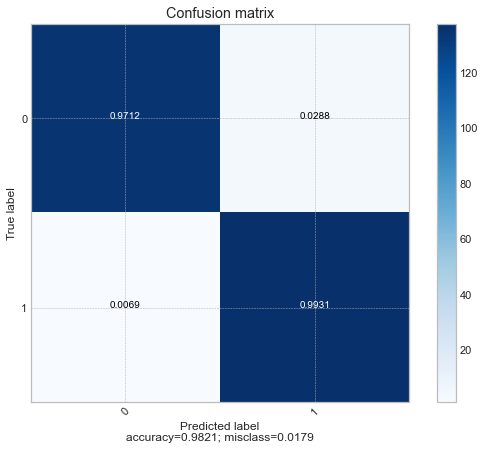

Confusion matrix:
[[134.61   3.99]
 [  0.96 137.64]]

              precision    recall  f1-score   support

           0     1.0000    0.9855    0.9927       138
           1     0.9858    1.0000    0.9929       139

    accuracy                         0.9928       277
   macro avg     0.9929    0.9928    0.9928       277
weighted avg     0.9929    0.9928    0.9928       277



In [70]:
xgbrf_model = XGBRFClassifier(n_jobs=-1, subsample=1.0, n_estimators=210, min_samples_split=32, min_samples_leaf=22, max_features=13, max_depth=85, learning_rate=0.11800000000000001)
xgbrf_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'XGBoostRF Classifier', xgbrf_model, 10, 100, verbose=False)

## 7.12 Real Model´s Performance

In [71]:
model_result_cv = pd.concat([nb_result_cv, dtc_result_cv, knn_result_cv, lr_result_cv, svm_result_cv, mlp_result_cv, keras_result_cv, xgb_result_cv, xgbrf_result_cv]) 
model_result_cv.sort_values('Accuracy_score',  ascending=False)

,Classifier Name,Accuracy_score
0,DecisionTreeClassifier,0.99 +/- 0.01
0,XGBoost Classifier,0.99 +/- 0.01
0,KNN Classifier,0.98 +/- 0.01
0,NeuralNertwork Classifier,0.98 +/- 0.01
0,XGBoostRF Classifier,0.98 +/- 0.01
0,SVM Classifier,0.96 +/- 0.01
0,LogisticRegression Classifier,0.95 +/- 0.01
0,Keras Classifier,0.89 +/- 0.03
0,Naive Bayes Classifier,0.89 +/- 0.02


# 8.0 HYPERPARAMETER FINE TUNNING

## 8.1 Random Search

{'n_estimators': 90, 'eta': 0.060000000000000005, 'max_depth': 15, 'subsample': 0.03, 'min_samples_split': 16, 'min_samples_leaf': 14, 'colsample_bytee': 0.6, 'min_child_weight': 9}


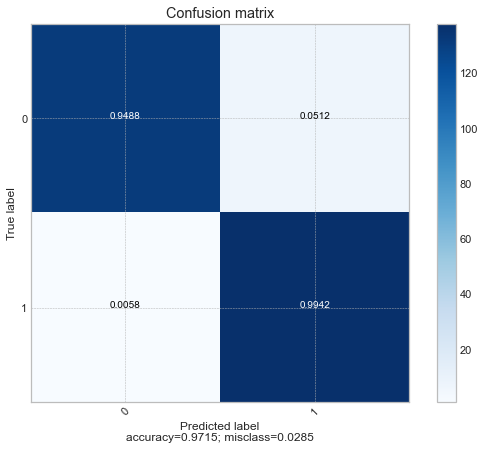

Confusion matrix:
[[131.5   7.1]
 [  0.8 137.8]]

              precision    recall  f1-score   support

           0     1.0000    0.9638    0.9815       138
           1     0.9653    1.0000    0.9823       139

    accuracy                         0.9819       277
   macro avg     0.9826    0.9819    0.9819       277
weighted avg     0.9826    0.9819    0.9819       277

{'n_estimators': 70, 'eta': 0.08, 'max_depth': 80, 'subsample': 0.02, 'min_samples_split': 18, 'min_samples_leaf': 16, 'colsample_bytee': 0.9, 'min_child_weight': 7}


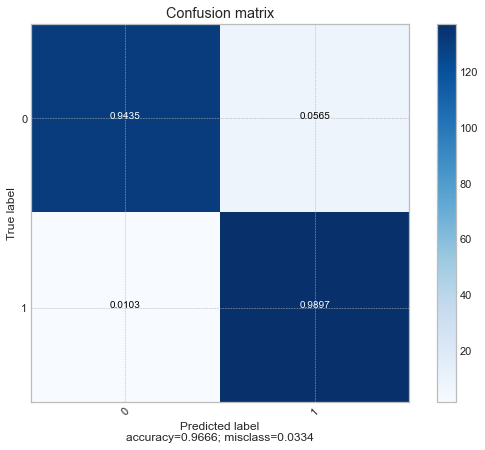

Confusion matrix:
[[130.76666667   7.83333333]
 [  1.43333333 137.16666667]]

              precision    recall  f1-score   support

           0     0.9926    0.9783    0.9854       138
           1     0.9787    0.9928    0.9857       139

    accuracy                         0.9856       277
   macro avg     0.9857    0.9855    0.9856       277
weighted avg     0.9857    0.9856    0.9856       277

{'n_estimators': 90, 'eta': 0.06999999999999999, 'max_depth': 90, 'subsample': 0.06999999999999999, 'min_samples_split': 30, 'min_samples_leaf': 30, 'colsample_bytee': 0.8, 'min_child_weight': 11}


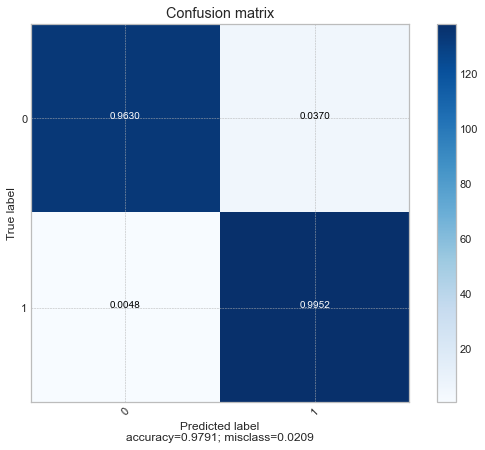

Confusion matrix:
[[133.46666667   5.13333333]
 [  0.66666667 137.93333333]]

              precision    recall  f1-score   support

           0     0.9853    0.9710    0.9781       138
           1     0.9716    0.9856    0.9786       139

    accuracy                         0.9783       277
   macro avg     0.9785    0.9783    0.9783       277
weighted avg     0.9784    0.9783    0.9783       277

{'n_estimators': 140, 'eta': 0.08, 'max_depth': 20, 'subsample': 0.03, 'min_samples_split': 18, 'min_samples_leaf': 16, 'colsample_bytee': 0.1, 'min_child_weight': 7}


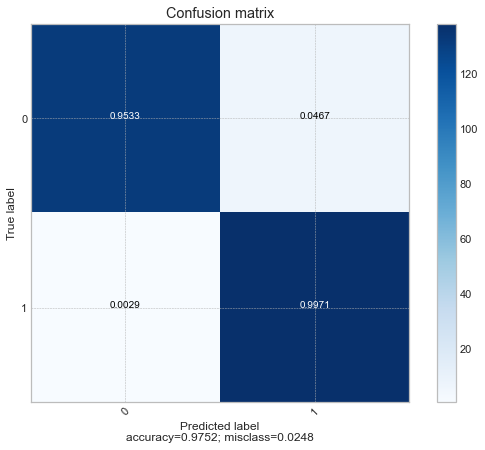

Confusion matrix:
[[132.13333333   6.46666667]
 [  0.4        138.2       ]]

              precision    recall  f1-score   support

           0     1.0000    0.9710    0.9853       138
           1     0.9720    1.0000    0.9858       139

    accuracy                         0.9856       277
   macro avg     0.9860    0.9855    0.9856       277
weighted avg     0.9860    0.9856    0.9856       277

{'n_estimators': 20, 'eta': 0.09, 'max_depth': 15, 'subsample': 0.02, 'min_samples_split': 28, 'min_samples_leaf': 24, 'colsample_bytee': 0.7000000000000001, 'min_child_weight': 4}


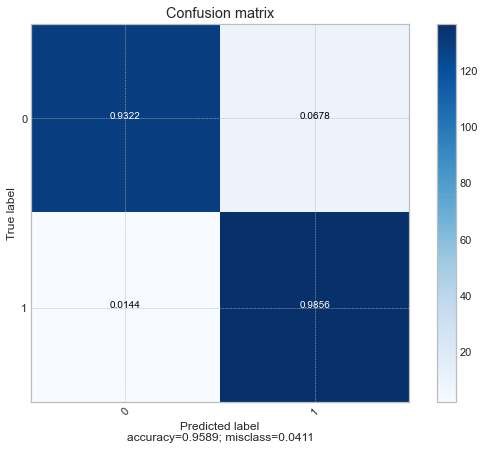

Confusion matrix:
[[129.2   9.4]
 [  2.  136.6]]

              precision    recall  f1-score   support

           0     0.9925    0.9565    0.9742       138
           1     0.9583    0.9928    0.9753       139

    accuracy                         0.9747       277
   macro avg     0.9754    0.9747    0.9747       277
weighted avg     0.9753    0.9747    0.9747       277

{'n_estimators': 80, 'eta': 0.03, 'max_depth': 100, 'subsample': 0.09, 'min_samples_split': 40, 'min_samples_leaf': 18, 'colsample_bytee': 0.7000000000000001, 'min_child_weight': 4}


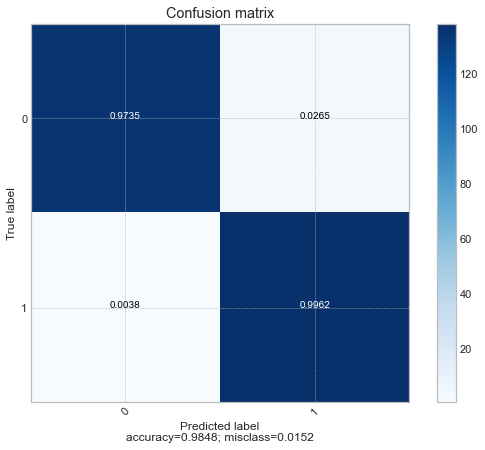

Confusion matrix:
[[134.93333333   3.66666667]
 [  0.53333333 138.06666667]]

              precision    recall  f1-score   support

           0     0.9854    0.9783    0.9818       138
           1     0.9786    0.9856    0.9821       139

    accuracy                         0.9819       277
   macro avg     0.9820    0.9819    0.9819       277
weighted avg     0.9820    0.9819    0.9819       277

{'n_estimators': 80, 'eta': 0.060000000000000005, 'max_depth': 75, 'subsample': 0.06999999999999999, 'min_samples_split': 4, 'min_samples_leaf': 2, 'colsample_bytee': 0.5, 'min_child_weight': 11}


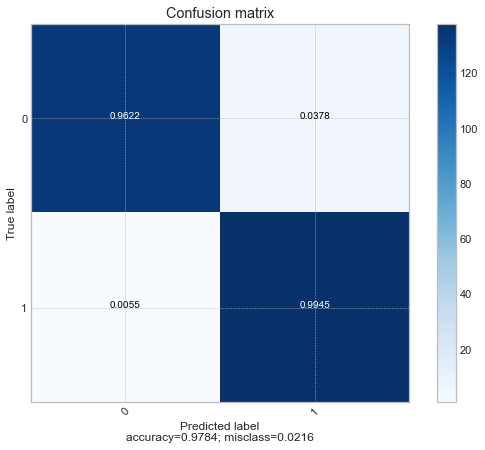

Confusion matrix:
[[133.36666667   5.23333333]
 [  0.76666667 137.83333333]]

              precision    recall  f1-score   support

           0     0.9853    0.9710    0.9781       138
           1     0.9716    0.9856    0.9786       139

    accuracy                         0.9783       277
   macro avg     0.9785    0.9783    0.9783       277
weighted avg     0.9784    0.9783    0.9783       277

{'n_estimators': 20, 'eta': 0.02, 'max_depth': 80, 'subsample': 0.08, 'min_samples_split': 18, 'min_samples_leaf': 24, 'colsample_bytee': 0.2, 'min_child_weight': 2}


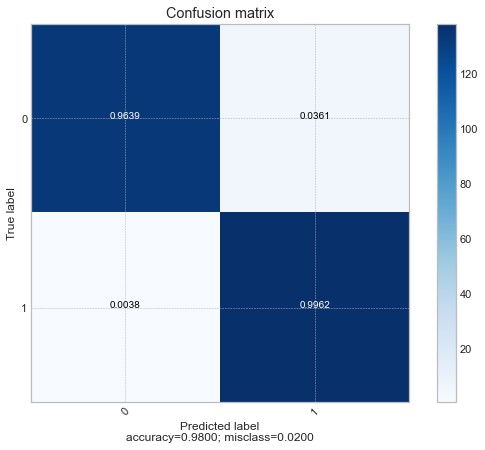

Confusion matrix:
[[133.6          5.        ]
 [  0.53333333 138.06666667]]

              precision    recall  f1-score   support

           0     0.9926    0.9710    0.9817       138
           1     0.9718    0.9928    0.9822       139

    accuracy                         0.9819       277
   macro avg     0.9822    0.9819    0.9819       277
weighted avg     0.9822    0.9819    0.9819       277

{'n_estimators': 10, 'eta': 0.04, 'max_depth': 20, 'subsample': 0.09, 'min_samples_split': 16, 'min_samples_leaf': 18, 'colsample_bytee': 0.9, 'min_child_weight': 12}


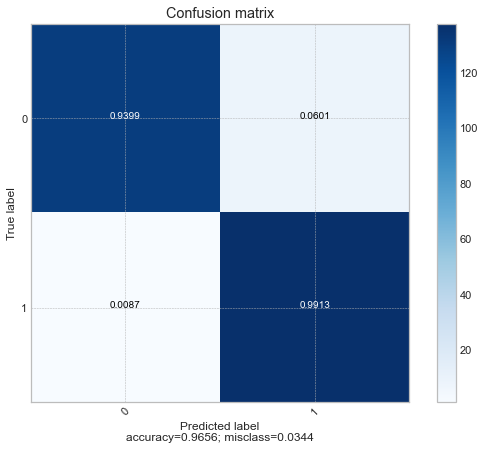

Confusion matrix:
[[130.26666667   8.33333333]
 [  1.2        137.4       ]]

              precision    recall  f1-score   support

           0     0.9851    0.9565    0.9706       138
           1     0.9580    0.9856    0.9716       139

    accuracy                         0.9711       277
   macro avg     0.9716    0.9711    0.9711       277
weighted avg     0.9715    0.9711    0.9711       277

{'n_estimators': 200, 'eta': 0.06999999999999999, 'max_depth': 25, 'subsample': 0.04, 'min_samples_split': 14, 'min_samples_leaf': 24, 'colsample_bytee': 0.9, 'min_child_weight': 10}


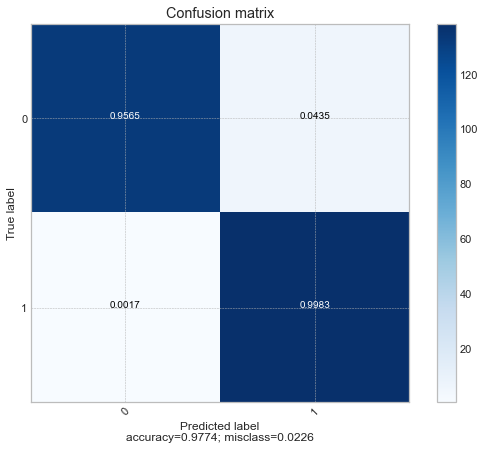

Confusion matrix:
[[132.56666667   6.03333333]
 [  0.23333333 138.36666667]]

              precision    recall  f1-score   support

           0     0.9926    0.9710    0.9817       138
           1     0.9718    0.9928    0.9822       139

    accuracy                         0.9819       277
   macro avg     0.9822    0.9819    0.9819       277
weighted avg     0.9822    0.9819    0.9819       277



,Classifier Name,Accuracy_score
0,XGBoost Classifier,0.97 +/- 0.01
0,XGBoost Classifier,0.97 +/- 0.01
0,XGBoost Classifier,0.98 +/- 0.01
0,XGBoost Classifier,0.98 +/- 0.01
0,XGBoost Classifier,0.96 +/- 0.01
0,XGBoost Classifier,0.98 +/- 0.01
0,XGBoost Classifier,0.98 +/- 0.01
0,XGBoost Classifier,0.98 +/- 0.01
0,XGBoost Classifier,0.97 +/- 0.01
0,XGBoost Classifier,0.98 +/- 0.01


In [116]:
import random
# criação de parâmetros
n_estimators      =  list(range(10,201,10)) # numeros de arvores
eta               = np.arange(0.01, 0.10, 0.01).tolist()
max_depth         = list(range(5,101,5))
subsample         = np.arange(0.01, 0.10, 0.01).tolist()
min_samples_split = list(range(2,41,2))
min_samples_leaf  = list(range(2,41,2))
colsample_bytee   = np.arange(0.1, 1, 0.1).tolist()
min_child_weight  = list(range(1,15,1))

param = {'n_estimators'      : n_estimators,
         'eta'               : eta,
         'max_depth'         : max_depth,
         'subsample'         : subsample,
         'min_samples_split' : min_samples_split,
         'min_samples_leaf'  : min_samples_leaf,
         'colsample_bytee'   : colsample_bytee,
         'min_child_weight'  : min_child_weight
        }

# executando o fine tunning
MAX_EVAL = 10
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    # choose values for parameters randomly
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print(hp)
    # Classifier
    random_xgb = XGBClassifier(objective='reg:squarederror',
                               n_estimators     = hp['n_estimators'],
                               eta              = hp['eta'],
                               max_depth        = hp['max_depth'],
                               subsample        = hp['subsample'],
                               colsample_bytee  = hp['colsample_bytee'],
                               min_child_weight = hp['min_child_weight'])
    
    # performance
    xgb_result_rscv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'XGBoost Classifier', random_xgb, 10, 3, verbose=False)
    final_result = pd.concat( [final_result, xgb_result_rscv] )

final_result

## 8.2 Baseline Classifier - Majority Learner/ZeroR

In [78]:
# Baseline classifier y_test
counter = collections.Counter(y_test)
base_line= np.array( [ counter[0] / (counter[0] + counter[1]), counter[1] / (counter[0] + counter[1]) ] )
base_line.max()

0.8275

## 8.3 Final Model Training

In [70]:
df_X_test_final = df_test.copy()

(unique, counts) = numpy.unique(y_test, return_counts=True)
frequencies = numpy.asarray((unique, counts)).T

print(frequencies)

[[  0 331]
 [  1  69]]


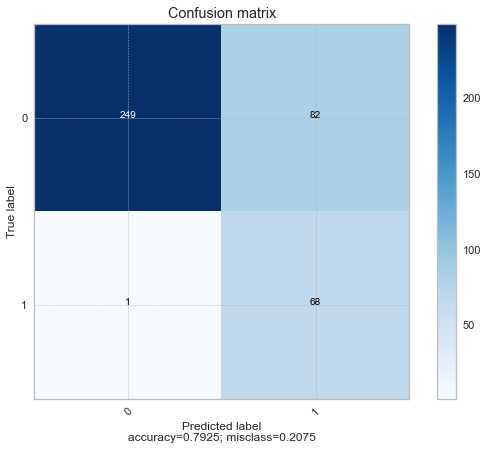

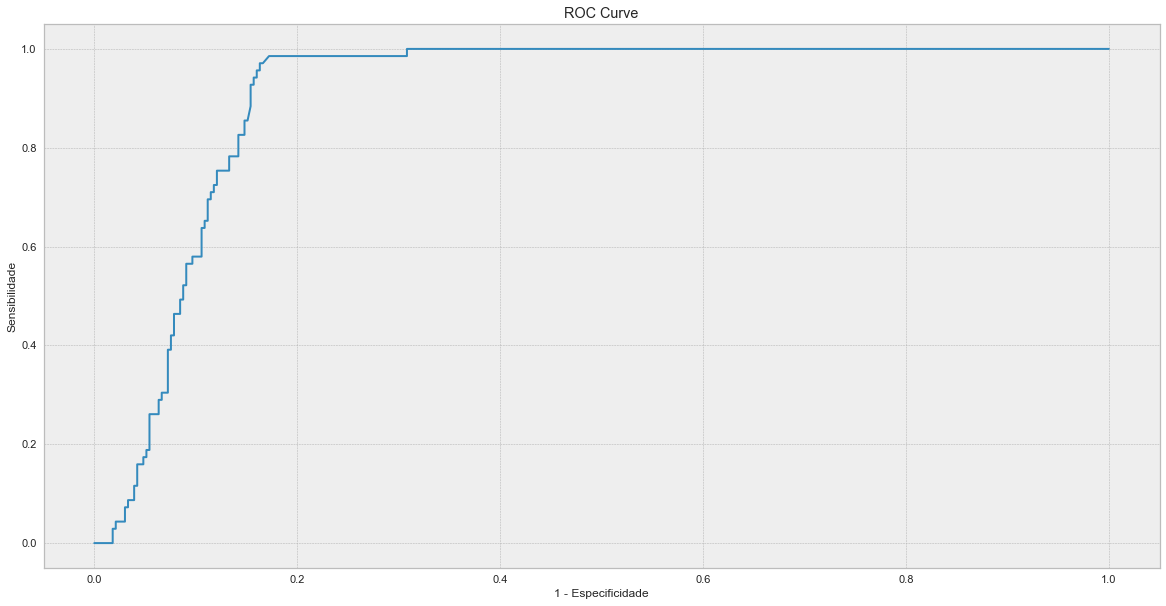

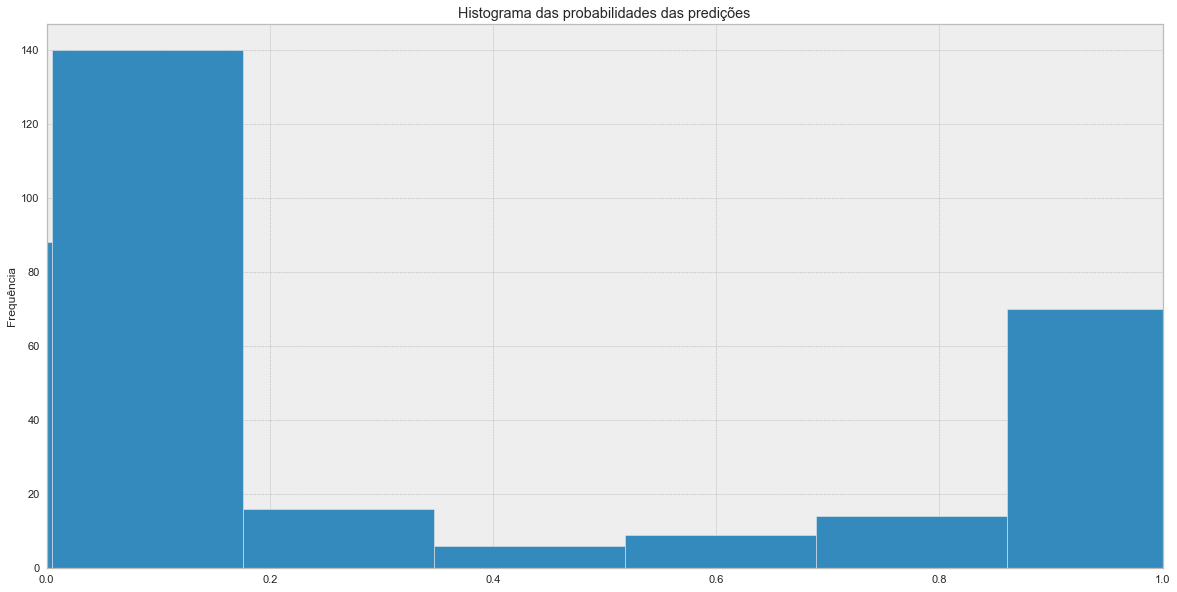

Confusion matrix |
[[249  82]
 [  1  68]]

              precision    recall  f1-score   support

           0     0.9960    0.7523    0.8571       331
           1     0.4533    0.9855    0.6210        69

    accuracy                         0.7925       400
   macro avg     0.7247    0.8689    0.7391       400
weighted avg     0.9024    0.7925    0.8164       400



,Classifier Name,Null accuracy,Accuracy score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,XGBClassifier,0.83,0.79,0.75,1.0,0.87,0.91,0.5,0.58


In [87]:
param_tuned = {'n_estimators': 200,
               'eta': 0.06999999999999999,
               'max_depth': 25,
               'subsample': 0.04,
               'min_samples_split': 14,
               'min_samples_leaf': 24,
               'colsample_bytee': 0.9,
               'min_child_weight': 10
              }

# Create classifier
classifier_xgb_tuned = XGBClassifier(objective='reg:squarederror',
                                     n_estimators     = param_tuned['n_estimators'],
                                     eta              = param_tuned['eta'],
                                     max_depth        = param_tuned['max_depth'],
                                     subsample        = param_tuned['subsample'],
                                     colsample_bytee  = param_tuned['colsample_bytee'],
                                     min_child_weight = param_tuned['min_child_weight'])

# training classifier
classifier_xgb_tuned.fit(X_df_train_resampled, y_df_train_resampled.values.ravel())

# apply transformations to test dataset
home_path     = 'C:/DADOS/Fabyo/InteligenciaArtificial/CreditAnalysis/'
loan_scaler   = pickle.load( open( home_path + 'parameter/loan_scaler.pkl',   'rb' ) )
income_scaler = pickle.load( open( home_path + 'parameter/income_scaler.pkl', 'rb' ) )
age_scaler    = pickle.load( open( home_path + 'parameter/age_scaler.pkl',    'rb' ) )

# Aplica RobustScaler nas variáveis com Outliers
# loan
df_X_test_final['loan']   = loan_scaler.fit_transform(df_X_test_final[['loan']].values)

# Aplica MinMaxScaler nas variáveis sem Outliers
# income
df_X_test_final['income'] = income_scaler.fit_transform(df_X_test_final[['income']].values)
# age
df_X_test_final['age']    = age_scaler.fit_transform(df_X_test_final[['age']].values)

# prediction
y_pred_tuned = classifier_xgb_tuned.predict(df_X_test_final)
y_proba      = classifier_xgb_tuned.predict_proba(df_X_test_final)

# metrics

## null_accuracy
null_accuracy = pd.Series(y_test).value_counts()
null_accuracy = null_accuracy[0]/(null_accuracy[0]+null_accuracy[1])

## accuracy_score
accuracy = accuracy_score(y_test, y_pred_tuned)

## Balanced Accuracy - Very goog to multi class analyses. Get all classes accuracy and extract the average. 
balanced_acc = balanced_accuracy_score(y_test, y_pred_tuned)

## Kappa score
kappa_acc = cohen_kappa_score( y_test, y_pred_tuned )

# roc curve
y_proba = y_proba[:, 1]
auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# confusion matrix
conf_matrix = confusion_matrix( y_test, y_pred_tuned )
TP = conf_matrix[1,1]
TN = conf_matrix[0,0]
FP = conf_matrix[0,1]
FN = conf_matrix[1,0]

# matthews_corrcoef - First, It is a metric that takes into account all the possibilities of a binary classification problem (TP, TN, FP and FN).
#                            It is robust to unbalanced datasets. The result of it is a normalized coefficient between -1 and 1 that is easy to interpret.
#
#                            -1 : the closer your MCC is to -1, the worse your classifier is. In other words, he is making more mistakes than he gets right.
#                            +1 : on the other hand, the closer to +1, the better your classifier. That is, he is hitting more than he misses.
#                             0 : when the coefficient is close to 0, it shows that the classifier is just "kicking" the most frequent class (es).        
mcc = matthews_corrcoef( y_test, y_pred_tuned )

# Specificity - How good the algorithm is at hitting the negative class. In other words: "Of the negative samples, how many did the algorithm get right?
specificity = TN / ( TN+FP )

# NPV - Negative Predictive Value - How much you trust the negative class prediction. In other words: “Of the samples that my algorithm said were negative, how many really are?
npv = TN / (TN + FN)

# plot confusion matrix
udf_plot_confusion_matrix(conf_matrix, [0, 1], normalize=False)

# plot roc curve
plot_roc_curve(fpr, tpr)

# plot histogram
plt.hist(y_proba, bins=8)
plt.xlim(0,1)
plt.title('Histograma das probabilidades das predições')
plt.ylabel('Frequência')
plt.show()

# classification_report
classification_dict = classification_report( y_test, y_pred_tuned, digits=4, output_dict=True )

print( 'Confusion matrix |\n{}\n'.format(conf_matrix) )
print( classification_report( y_test, y_pred_tuned, digits=4) )

df_classifier_result = pd.DataFrame(
    {
        'Classifier Name'                  : 'XGBClassifier',
        'Null accuracy'                    : np.round( null_accuracy, 2 ).astype(str),
        'Accuracy score'                   : np.round( accuracy, 2 ).astype(str),
        'Specificity'                      : np.round( specificity, 2 ).astype(str),
        'NPV'                              : np.round( npv, 2 ).astype(str),
        'Balanced Accuracy score'          : np.round( balanced_acc, 2 ).astype(str),
        'AUC'                              : np.round( auc, 2 ).astype(str),
        'Kappa score'                      : np.round( kappa_acc, 2 ).astype(str),
        'Matthews Correlation Coefficient' : np.round( mcc, 2 ).astype(str)
    },
    index=[0]
)

# Saving trained model
pickle.dump( classifier_xgb_tuned, open('model_credit_analysis.pkl', 'wb') )


df_classifier_result.head()

# 9.0 MODEL TRANSLATION AND INTERPRETATION

In [89]:
# get precision per target
data = { 'prediction' : [0, 1], 'precision':[classification_dict.get('0').get('precision'), classification_dict.get('1').get('precision')] }
df_precision = pd.DataFrame(data)
df_precision.head()

predict_agg_sum   = df_predict[['prediction', 'loan']].groupby('prediction').sum().reset_index()
predict_agg_count = df_predict[['prediction', 'loan']].groupby('prediction').size().to_frame('customers_count').reset_index()

predict_agg_count.head()

# join dataframes
df_predict_agg = pd.merge(predict_agg_sum, predict_agg_count, how='left', on='prediction')
df_predict_agg = pd.merge(df_predict_agg, df_precision, how='left', on='prediction')
df_predict_agg['customers_percent'] = df_predict_agg['customers_count']/df_predict_agg['customers_count'].sum()*100.00
df_predict_agg['warranted_values']  = np.round(df_predict_agg['loan'] * df_predict_agg['precision'], 2)
df_predict_agg['loss_margin']       = df_predict_agg['loan'] * (1-df_predict_agg['precision'])

# format values
df_predict_agg['loan']  = df_predict_agg['loan'].map( 'R$ {:,.2f}'.format )
df_predict_agg['warranted_values']  = df_predict_agg['warranted_values'].map( 'R$ {:,.2f}'.format )
df_predict_agg['loss_margin']       = df_predict_agg['loss_margin'].map( 'R$ {:,.2f}'.format )

predict_map = {0:'will pay', 1:'won´t pay'}
df_predict_agg['prediction'] = df_predict_agg['prediction'].map(predict_map)

df_predict_agg.head()

,prediction,loan,customers_count,precision,customers_percent,warranted_values,loss_margin
0,will pay,"R$ 948,642.06",262,0.992366,65.5,"R$ 941,400.52","R$ 7,241.54"
1,won´t pay,"R$ 894,078.00",138,0.485507,34.5,"R$ 434,081.35","R$ 459,996.65"


# 10.0 DEPLOY MODEL TO PRODUCTON

## 10.1 Credit Analysis Class

In [ ]:
import pickle
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer

class CreditAnalysis( object ):
    def __init__( self ):
        self.home_path='C:/DADOS/Fabyo/InteligenciaArtificial/CreditAnalysis/'
        self.loan_scaler   = pickle.load( open( self.home_path + 'parameter/loan_scaler.pkl',   'rb' ) )
        self.income_scaler = pickle.load( open( self.home_path + 'parameter/income_scaler.pkl', 'rb' ) )
        self.age_scaler    = pickle.load( open( self.home_path + 'parameter/age_scaler.pkl',    'rb' ) )
        
    def data_preprocessing(self, df1):
        # fillout missing values
        # Create object SimpleImputer
        si = SimpleImputer(missing_values=np.nan, strategy='mean')

        # apply SimpleImputer
        si.fit(X=df1)

        # reconstruct new dataframe with imputed set
        df2 = pd.DataFrame.from_records(
            data=si.transform(
                X=df1
            ),  # SimpleImputer.transform(<<pandas dataframe>>) result is a list of lists
            columns=df1.columns  # keep originals columns
        ).astype(dtype={'i#clientid': 'uint16', 'income': 'float32', 'age': 'float32', 'loan': 'float32'})
        
        # treating negative ages
        # get mean age>0
        age_mean = df2['age'][df2.age>0].mean()

        # applying mean to negative ages
        df2.loc[df2.age < 0, 'age'] = age_mean

        return df2
    
    def feature_engineering( self, df2 ):
        # Income
        df2['income_type'] = df2['income'].apply(lambda x: 'low' if x<35000 else 'mid' if (x>=35000) & (x<50000) else 'high' ).astype('category')

        # Age
        df2['age_type'] = df2['age'].apply(lambda x: 'young' if x<=30 else 'mid' if (x>30) & (x<60) else 'high' ).astype('category')

        # loan
        df2['loan_type'] = df2['loan'].apply(lambda x: 'low' if x<=2000 else 'mid' if (x>2000) & (x<6000) else 'high' ).astype('category')
        
        return df2
    
    def data_preparation( self, df5 ):
        # we´ll use a dict to associate the category with its hierarchy
        ordinal_dict       = { 'low':1, 'mid':2, 'high':3 }
        df5['income_type'] = df5['income_type'].map( ordinal_dict ).astype('int8')
        df5['loan_type']   = df5['loan_type'].map( ordinal_dict ).astype('int8')

        ordinal_dict       = { 'young':1, 'mid':2, 'high':3 }
        df5['age_type']    = df5['age_type'].map( ordinal_dict ).astype('int8')

        # Aplica RobustScaler nas variáveis com Outliers
        # loan
        df5['loan']   = self.loan_scaler.fit_transform(df5[['loan']].values)
        
        # Aplica MinMaxScaler nas variáveis sem Outliers
        # income
        df5['income'] = self.income_scaler.fit_transform(df5[['income']].values)
        # age
        df5['age']    = self.age_scaler.fit_transform(df5[['age']].values)
        
        cols_selected = ['income', 'age', 'loan', 'loan_type', 'age_type', 'income_type']

        return df5[cols_selected]
    
    def get_prediction( self, model, original_data, test_data):
        
        #prediction
        pred = model.predict( test_data )

        test_data.to_csv(r'test_d.csv', index = False)
        
        # join pred into the original data
        original_data['prediction'] = pred
        
        return original_data.to_json( orient='records' )


## 10.2 API Handler

In [ ]:
import pickle
import pandas as pd
import json
from flask                         import Flask, request, Response
from creditanalysis.CreditAnalysis import CreditAnalysis

# loading model
model = pickle.load(open('C:/DADOS/Fabyo/InteligenciaArtificial/CreditAnalysis/model_credit_analysis.pkl', 'rb'))

# instantiate flask
app = Flask( __name__ )

#create endpoint
@app.route('/creditanalysis/predict', methods=['POST'])

# when ednpoint receive a call by POST it executes the first function below the call
def credit_predict():
    test_json = request.get_json()
    
    #check if receive json data
    if test_json: # there is data
        if isinstance(test_json, dict): # check if is dict
            # unique example
            test_raw = pd.DataFrame( test_json, index=[0] ) 
        else:
            # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() ) #get json keys/columns
    else:
        # requisition ok, but with no data to predict
        return Response( '{}', status=200, mimetype='application/json' )
    
    # Instantiate CreditAnalysis class
    pipeline = CreditAnalysis()
    
    # data preprocessing
    df1 = pipeline.data_preprocessing( test_raw )
    
    # feature engineering
    df2 = pipeline.feature_engineering( df1 )

    # data preparation
    df3 = pipeline.data_preparation( df2 )

    # prediction
    df_response = pipeline.get_prediction( model, test_raw, df3 )
    
    return df_response

if __name__ == '__main__':
    app.run( 'localhost', debug=True, use_debugger=False, use_reloader=True )

## 10.3 API Tester

In [ ]:
# Convert dataframe to json
import json
import requests

df_test_api = pd.read_csv('data/test.csv')
data = json.dumps( df_test_api.to_dict( orient='records' ) )

In [ ]:
# API Call
#url    = 'http://localhost:5000/creditanalysis/predict'
url    = 'https://credit-analysis-prediction.herokuapp.com/creditanalysis/predict'
header = {'Content-type': 'application/json'}
data   = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1